##### Задание 1
Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [ ]:
Целевая переменная--наличие сердечно-сосудистых заболеваний

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
Добавим классификатор Catboost и запустим кросс-валидацию

##### Задание 3
Обучить любой классификатор (какой вам нравится)catboost

In [6]:
from catboost import CatBoostClassifier

In [7]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

Learning rate set to 0.054384
0:	learn: 0.6773311	total: 215ms	remaining: 3m 34s
1:	learn: 0.6632305	total: 238ms	remaining: 1m 58s
2:	learn: 0.6503666	total: 262ms	remaining: 1m 27s
3:	learn: 0.6396177	total: 285ms	remaining: 1m 10s
4:	learn: 0.6297571	total: 302ms	remaining: 1m
5:	learn: 0.6212134	total: 321ms	remaining: 53.2s
6:	learn: 0.6132598	total: 339ms	remaining: 48.1s
7:	learn: 0.6061406	total: 356ms	remaining: 44.1s
8:	learn: 0.6004066	total: 373ms	remaining: 41.1s
9:	learn: 0.5947673	total: 390ms	remaining: 38.6s
10:	learn: 0.5895150	total: 410ms	remaining: 36.8s
11:	learn: 0.5850119	total: 430ms	remaining: 35.4s
12:	learn: 0.5811455	total: 448ms	remaining: 34s
13:	learn: 0.5777210	total: 465ms	remaining: 32.7s
14:	learn: 0.5744220	total: 481ms	remaining: 31.6s
15:	learn: 0.5715707	total: 497ms	remaining: 30.6s
16:	learn: 0.5690200	total: 514ms	remaining: 29.7s
17:	learn: 0.5667040	total: 545ms	remaining: 29.7s
18:	learn: 0.5645527	total: 577ms	remaining: 29.8s
19:	learn: 0

160:	learn: 0.5319876	total: 3.63s	remaining: 18.9s
161:	learn: 0.5319870	total: 3.66s	remaining: 18.9s
162:	learn: 0.5319342	total: 3.68s	remaining: 18.9s
163:	learn: 0.5318985	total: 3.7s	remaining: 18.9s
164:	learn: 0.5318691	total: 3.71s	remaining: 18.8s
165:	learn: 0.5318453	total: 3.73s	remaining: 18.7s
166:	learn: 0.5318243	total: 3.75s	remaining: 18.7s
167:	learn: 0.5317993	total: 3.76s	remaining: 18.6s
168:	learn: 0.5317584	total: 3.79s	remaining: 18.7s
169:	learn: 0.5317036	total: 3.81s	remaining: 18.6s
170:	learn: 0.5316774	total: 3.84s	remaining: 18.6s
171:	learn: 0.5315996	total: 3.86s	remaining: 18.6s
172:	learn: 0.5315508	total: 3.88s	remaining: 18.5s
173:	learn: 0.5314525	total: 3.9s	remaining: 18.5s
174:	learn: 0.5314329	total: 3.93s	remaining: 18.5s
175:	learn: 0.5313876	total: 3.96s	remaining: 18.6s
176:	learn: 0.5313196	total: 4s	remaining: 18.6s
177:	learn: 0.5312903	total: 4.02s	remaining: 18.6s
178:	learn: 0.5312154	total: 4.04s	remaining: 18.5s
179:	learn: 0.531

328:	learn: 0.5247853	total: 7.21s	remaining: 14.7s
329:	learn: 0.5247501	total: 7.24s	remaining: 14.7s
330:	learn: 0.5247005	total: 7.25s	remaining: 14.7s
331:	learn: 0.5246578	total: 7.27s	remaining: 14.6s
332:	learn: 0.5246236	total: 7.29s	remaining: 14.6s
333:	learn: 0.5245804	total: 7.31s	remaining: 14.6s
334:	learn: 0.5245625	total: 7.34s	remaining: 14.6s
335:	learn: 0.5245348	total: 7.36s	remaining: 14.5s
336:	learn: 0.5244829	total: 7.38s	remaining: 14.5s
337:	learn: 0.5244378	total: 7.41s	remaining: 14.5s
338:	learn: 0.5243723	total: 7.43s	remaining: 14.5s
339:	learn: 0.5243353	total: 7.46s	remaining: 14.5s
340:	learn: 0.5243018	total: 7.49s	remaining: 14.5s
341:	learn: 0.5242525	total: 7.5s	remaining: 14.4s
342:	learn: 0.5242192	total: 7.54s	remaining: 14.4s
343:	learn: 0.5241982	total: 7.57s	remaining: 14.4s
344:	learn: 0.5241629	total: 7.58s	remaining: 14.4s
345:	learn: 0.5241070	total: 7.61s	remaining: 14.4s
346:	learn: 0.5241038	total: 7.63s	remaining: 14.4s
347:	learn: 0

496:	learn: 0.5179318	total: 11.1s	remaining: 11.2s
497:	learn: 0.5178899	total: 11.1s	remaining: 11.2s
498:	learn: 0.5178534	total: 11.1s	remaining: 11.2s
499:	learn: 0.5178330	total: 11.1s	remaining: 11.1s
500:	learn: 0.5178220	total: 11.1s	remaining: 11.1s
501:	learn: 0.5177713	total: 11.2s	remaining: 11.1s
502:	learn: 0.5177372	total: 11.2s	remaining: 11.1s
503:	learn: 0.5176979	total: 11.2s	remaining: 11s
504:	learn: 0.5176674	total: 11.2s	remaining: 11s
505:	learn: 0.5176414	total: 11.3s	remaining: 11s
506:	learn: 0.5176049	total: 11.3s	remaining: 11s
507:	learn: 0.5175754	total: 11.3s	remaining: 11s
508:	learn: 0.5175474	total: 11.3s	remaining: 10.9s
509:	learn: 0.5174928	total: 11.4s	remaining: 10.9s
510:	learn: 0.5174675	total: 11.4s	remaining: 10.9s
511:	learn: 0.5174069	total: 11.4s	remaining: 10.9s
512:	learn: 0.5173788	total: 11.4s	remaining: 10.8s
513:	learn: 0.5173328	total: 11.4s	remaining: 10.8s
514:	learn: 0.5173026	total: 11.5s	remaining: 10.8s
515:	learn: 0.5172496	

655:	learn: 0.5124390	total: 14.6s	remaining: 7.66s
656:	learn: 0.5123917	total: 14.6s	remaining: 7.64s
657:	learn: 0.5123578	total: 14.7s	remaining: 7.62s
658:	learn: 0.5123437	total: 14.7s	remaining: 7.59s
659:	learn: 0.5123116	total: 14.7s	remaining: 7.57s
660:	learn: 0.5122964	total: 14.7s	remaining: 7.54s
661:	learn: 0.5122478	total: 14.7s	remaining: 7.52s
662:	learn: 0.5122470	total: 14.8s	remaining: 7.5s
663:	learn: 0.5122236	total: 14.8s	remaining: 7.48s
664:	learn: 0.5121815	total: 14.8s	remaining: 7.45s
665:	learn: 0.5121435	total: 14.8s	remaining: 7.43s
666:	learn: 0.5121324	total: 14.8s	remaining: 7.41s
667:	learn: 0.5120902	total: 14.9s	remaining: 7.39s
668:	learn: 0.5120597	total: 14.9s	remaining: 7.36s
669:	learn: 0.5120292	total: 14.9s	remaining: 7.33s
670:	learn: 0.5119569	total: 14.9s	remaining: 7.32s
671:	learn: 0.5119045	total: 14.9s	remaining: 7.29s
672:	learn: 0.5118636	total: 15s	remaining: 7.27s
673:	learn: 0.5118285	total: 15s	remaining: 7.25s
674:	learn: 0.511

820:	learn: 0.5071008	total: 18.2s	remaining: 3.96s
821:	learn: 0.5070761	total: 18.2s	remaining: 3.94s
822:	learn: 0.5070532	total: 18.2s	remaining: 3.92s
823:	learn: 0.5070453	total: 18.2s	remaining: 3.9s
824:	learn: 0.5070206	total: 18.3s	remaining: 3.87s
825:	learn: 0.5069845	total: 18.3s	remaining: 3.85s
826:	learn: 0.5069516	total: 18.3s	remaining: 3.83s
827:	learn: 0.5069226	total: 18.3s	remaining: 3.81s
828:	learn: 0.5069112	total: 18.4s	remaining: 3.79s
829:	learn: 0.5069004	total: 18.4s	remaining: 3.77s
830:	learn: 0.5068753	total: 18.4s	remaining: 3.74s
831:	learn: 0.5068390	total: 18.4s	remaining: 3.72s
832:	learn: 0.5068091	total: 18.4s	remaining: 3.7s
833:	learn: 0.5067779	total: 18.5s	remaining: 3.67s
834:	learn: 0.5067659	total: 18.5s	remaining: 3.65s
835:	learn: 0.5067421	total: 18.5s	remaining: 3.63s
836:	learn: 0.5067203	total: 18.5s	remaining: 3.61s
837:	learn: 0.5066838	total: 18.5s	remaining: 3.58s
838:	learn: 0.5066522	total: 18.6s	remaining: 3.56s
839:	learn: 0.

984:	learn: 0.5022910	total: 21.8s	remaining: 332ms
985:	learn: 0.5022644	total: 21.8s	remaining: 310ms
986:	learn: 0.5022305	total: 21.8s	remaining: 288ms
987:	learn: 0.5021803	total: 21.9s	remaining: 266ms
988:	learn: 0.5021793	total: 21.9s	remaining: 244ms
989:	learn: 0.5021606	total: 21.9s	remaining: 221ms
990:	learn: 0.5021428	total: 21.9s	remaining: 199ms
991:	learn: 0.5020981	total: 21.9s	remaining: 177ms
992:	learn: 0.5020830	total: 22s	remaining: 155ms
993:	learn: 0.5020565	total: 22s	remaining: 133ms
994:	learn: 0.5020385	total: 22s	remaining: 111ms
995:	learn: 0.5020198	total: 22s	remaining: 88.5ms
996:	learn: 0.5019951	total: 22.1s	remaining: 66.4ms
997:	learn: 0.5019760	total: 22.1s	remaining: 44.3ms
998:	learn: 0.5019476	total: 22.1s	remaining: 22.1ms
999:	learn: 0.5019301	total: 22.1s	remaining: 0us
Learning rate set to 0.054384
0:	learn: 0.6771065	total: 19ms	remaining: 19s
1:	learn: 0.6627095	total: 38.8ms	remaining: 19.4s
2:	learn: 0.6499988	total: 57.1ms	remaining: 1

146:	learn: 0.5320817	total: 3.15s	remaining: 18.3s
147:	learn: 0.5320209	total: 3.18s	remaining: 18.3s
148:	learn: 0.5319956	total: 3.19s	remaining: 18.2s
149:	learn: 0.5319274	total: 3.21s	remaining: 18.2s
150:	learn: 0.5318593	total: 3.23s	remaining: 18.1s
151:	learn: 0.5318024	total: 3.24s	remaining: 18.1s
152:	learn: 0.5317826	total: 3.26s	remaining: 18s
153:	learn: 0.5317406	total: 3.27s	remaining: 18s
154:	learn: 0.5317054	total: 3.3s	remaining: 18s
155:	learn: 0.5316663	total: 3.33s	remaining: 18s
156:	learn: 0.5316086	total: 3.35s	remaining: 18s
157:	learn: 0.5315404	total: 3.37s	remaining: 18s
158:	learn: 0.5314787	total: 3.39s	remaining: 17.9s
159:	learn: 0.5314492	total: 3.41s	remaining: 17.9s
160:	learn: 0.5313985	total: 3.43s	remaining: 17.9s
161:	learn: 0.5313632	total: 3.44s	remaining: 17.8s
162:	learn: 0.5312919	total: 3.47s	remaining: 17.8s
163:	learn: 0.5312585	total: 3.5s	remaining: 17.9s
164:	learn: 0.5312137	total: 3.52s	remaining: 17.8s
165:	learn: 0.5311798	tota

305:	learn: 0.5252687	total: 6.72s	remaining: 15.2s
306:	learn: 0.5252186	total: 6.74s	remaining: 15.2s
307:	learn: 0.5251771	total: 6.76s	remaining: 15.2s
308:	learn: 0.5251189	total: 6.79s	remaining: 15.2s
309:	learn: 0.5250717	total: 6.82s	remaining: 15.2s
310:	learn: 0.5250156	total: 6.84s	remaining: 15.1s
311:	learn: 0.5249695	total: 6.87s	remaining: 15.1s
312:	learn: 0.5249614	total: 6.9s	remaining: 15.1s
313:	learn: 0.5249269	total: 6.92s	remaining: 15.1s
314:	learn: 0.5248873	total: 6.95s	remaining: 15.1s
315:	learn: 0.5248537	total: 6.98s	remaining: 15.1s
316:	learn: 0.5248070	total: 7.01s	remaining: 15.1s
317:	learn: 0.5247864	total: 7.03s	remaining: 15.1s
318:	learn: 0.5247330	total: 7.06s	remaining: 15.1s
319:	learn: 0.5246860	total: 7.09s	remaining: 15.1s
320:	learn: 0.5246212	total: 7.11s	remaining: 15s
321:	learn: 0.5245327	total: 7.13s	remaining: 15s
322:	learn: 0.5245044	total: 7.14s	remaining: 15s
323:	learn: 0.5244672	total: 7.16s	remaining: 14.9s
324:	learn: 0.52443

473:	learn: 0.5184907	total: 10.7s	remaining: 11.9s
474:	learn: 0.5184527	total: 10.7s	remaining: 11.9s
475:	learn: 0.5184304	total: 10.7s	remaining: 11.8s
476:	learn: 0.5183916	total: 10.8s	remaining: 11.8s
477:	learn: 0.5183455	total: 10.8s	remaining: 11.8s
478:	learn: 0.5182945	total: 10.8s	remaining: 11.8s
479:	learn: 0.5182378	total: 10.8s	remaining: 11.7s
480:	learn: 0.5182012	total: 10.9s	remaining: 11.7s
481:	learn: 0.5181446	total: 10.9s	remaining: 11.7s
482:	learn: 0.5181062	total: 10.9s	remaining: 11.7s
483:	learn: 0.5181049	total: 10.9s	remaining: 11.6s
484:	learn: 0.5180590	total: 11s	remaining: 11.6s
485:	learn: 0.5180169	total: 11s	remaining: 11.6s
486:	learn: 0.5179764	total: 11s	remaining: 11.6s
487:	learn: 0.5179464	total: 11s	remaining: 11.6s
488:	learn: 0.5178732	total: 11.1s	remaining: 11.6s
489:	learn: 0.5178447	total: 11.1s	remaining: 11.5s
490:	learn: 0.5178015	total: 11.1s	remaining: 11.5s
491:	learn: 0.5177805	total: 11.1s	remaining: 11.5s
492:	learn: 0.517720

641:	learn: 0.5124047	total: 14.5s	remaining: 8.09s
642:	learn: 0.5123649	total: 14.5s	remaining: 8.07s
643:	learn: 0.5123345	total: 14.5s	remaining: 8.04s
644:	learn: 0.5123135	total: 14.6s	remaining: 8.02s
645:	learn: 0.5122703	total: 14.6s	remaining: 7.99s
646:	learn: 0.5122126	total: 14.6s	remaining: 7.97s
647:	learn: 0.5121758	total: 14.6s	remaining: 7.94s
648:	learn: 0.5121175	total: 14.7s	remaining: 7.92s
649:	learn: 0.5120788	total: 14.7s	remaining: 7.9s
650:	learn: 0.5120563	total: 14.7s	remaining: 7.88s
651:	learn: 0.5120163	total: 14.7s	remaining: 7.86s
652:	learn: 0.5119838	total: 14.7s	remaining: 7.83s
653:	learn: 0.5119454	total: 14.8s	remaining: 7.8s
654:	learn: 0.5119101	total: 14.8s	remaining: 7.78s
655:	learn: 0.5118825	total: 14.8s	remaining: 7.76s
656:	learn: 0.5118357	total: 14.8s	remaining: 7.74s
657:	learn: 0.5117690	total: 14.9s	remaining: 7.72s
658:	learn: 0.5117661	total: 14.9s	remaining: 7.7s
659:	learn: 0.5117385	total: 14.9s	remaining: 7.68s
660:	learn: 0.5

803:	learn: 0.5070631	total: 18.3s	remaining: 4.45s
804:	learn: 0.5070186	total: 18.3s	remaining: 4.43s
805:	learn: 0.5069817	total: 18.3s	remaining: 4.4s
806:	learn: 0.5069494	total: 18.3s	remaining: 4.38s
807:	learn: 0.5068990	total: 18.3s	remaining: 4.36s
808:	learn: 0.5068816	total: 18.4s	remaining: 4.33s
809:	learn: 0.5068749	total: 18.4s	remaining: 4.31s
810:	learn: 0.5068364	total: 18.4s	remaining: 4.29s
811:	learn: 0.5067911	total: 18.4s	remaining: 4.27s
812:	learn: 0.5067704	total: 18.5s	remaining: 4.25s
813:	learn: 0.5067493	total: 18.5s	remaining: 4.22s
814:	learn: 0.5067114	total: 18.5s	remaining: 4.2s
815:	learn: 0.5066843	total: 18.5s	remaining: 4.17s
816:	learn: 0.5066497	total: 18.5s	remaining: 4.15s
817:	learn: 0.5066426	total: 18.6s	remaining: 4.13s
818:	learn: 0.5065760	total: 18.6s	remaining: 4.1s
819:	learn: 0.5065443	total: 18.6s	remaining: 4.08s
820:	learn: 0.5064946	total: 18.6s	remaining: 4.06s
821:	learn: 0.5064861	total: 18.6s	remaining: 4.03s
822:	learn: 0.5

962:	learn: 0.5023700	total: 21.8s	remaining: 838ms
963:	learn: 0.5023475	total: 21.8s	remaining: 815ms
964:	learn: 0.5023241	total: 21.8s	remaining: 792ms
965:	learn: 0.5022879	total: 21.9s	remaining: 769ms
966:	learn: 0.5022494	total: 21.9s	remaining: 747ms
967:	learn: 0.5022188	total: 21.9s	remaining: 725ms
968:	learn: 0.5021899	total: 21.9s	remaining: 702ms
969:	learn: 0.5021882	total: 22s	remaining: 680ms
970:	learn: 0.5021579	total: 22s	remaining: 657ms
971:	learn: 0.5021372	total: 22s	remaining: 634ms
972:	learn: 0.5021105	total: 22s	remaining: 611ms
973:	learn: 0.5020949	total: 22s	remaining: 588ms
974:	learn: 0.5020455	total: 22.1s	remaining: 566ms
975:	learn: 0.5020042	total: 22.1s	remaining: 543ms
976:	learn: 0.5019650	total: 22.1s	remaining: 521ms
977:	learn: 0.5019287	total: 22.1s	remaining: 498ms
978:	learn: 0.5019005	total: 22.1s	remaining: 475ms
979:	learn: 0.5018632	total: 22.2s	remaining: 453ms
980:	learn: 0.5018129	total: 22.2s	remaining: 430ms
981:	learn: 0.5017561	

128:	learn: 0.5340001	total: 3s	remaining: 20.2s
129:	learn: 0.5339561	total: 3.02s	remaining: 20.2s
130:	learn: 0.5339020	total: 3.05s	remaining: 20.2s
131:	learn: 0.5338283	total: 3.08s	remaining: 20.3s
132:	learn: 0.5337980	total: 3.11s	remaining: 20.3s
133:	learn: 0.5337702	total: 3.13s	remaining: 20.3s
134:	learn: 0.5337392	total: 3.15s	remaining: 20.2s
135:	learn: 0.5337108	total: 3.17s	remaining: 20.2s
136:	learn: 0.5336572	total: 3.19s	remaining: 20.1s
137:	learn: 0.5336099	total: 3.21s	remaining: 20s
138:	learn: 0.5335776	total: 3.23s	remaining: 20s
139:	learn: 0.5335548	total: 3.24s	remaining: 19.9s
140:	learn: 0.5335281	total: 3.25s	remaining: 19.8s
141:	learn: 0.5334576	total: 3.28s	remaining: 19.8s
142:	learn: 0.5334195	total: 3.3s	remaining: 19.8s
143:	learn: 0.5333962	total: 3.34s	remaining: 19.8s
144:	learn: 0.5333389	total: 3.36s	remaining: 19.8s
145:	learn: 0.5332783	total: 3.38s	remaining: 19.8s
146:	learn: 0.5332186	total: 3.41s	remaining: 19.8s
147:	learn: 0.533145

293:	learn: 0.5268675	total: 7.65s	remaining: 18.4s
294:	learn: 0.5268157	total: 7.68s	remaining: 18.4s
295:	learn: 0.5267891	total: 7.71s	remaining: 18.3s
296:	learn: 0.5267279	total: 7.74s	remaining: 18.3s
297:	learn: 0.5266726	total: 7.78s	remaining: 18.3s
298:	learn: 0.5265948	total: 7.81s	remaining: 18.3s
299:	learn: 0.5265581	total: 7.84s	remaining: 18.3s
300:	learn: 0.5265358	total: 7.85s	remaining: 18.2s
301:	learn: 0.5264744	total: 7.88s	remaining: 18.2s
302:	learn: 0.5264273	total: 7.9s	remaining: 18.2s
303:	learn: 0.5264047	total: 7.92s	remaining: 18.1s
304:	learn: 0.5263527	total: 7.93s	remaining: 18.1s
305:	learn: 0.5262921	total: 7.95s	remaining: 18s
306:	learn: 0.5262474	total: 7.97s	remaining: 18s
307:	learn: 0.5261954	total: 8s	remaining: 18s
308:	learn: 0.5261905	total: 8.01s	remaining: 17.9s
309:	learn: 0.5261329	total: 8.04s	remaining: 17.9s
310:	learn: 0.5260982	total: 8.06s	remaining: 17.9s
311:	learn: 0.5260542	total: 8.09s	remaining: 17.8s
312:	learn: 0.5260392	

453:	learn: 0.5206369	total: 11.2s	remaining: 13.4s
454:	learn: 0.5206021	total: 11.2s	remaining: 13.4s
455:	learn: 0.5205603	total: 11.2s	remaining: 13.3s
456:	learn: 0.5205146	total: 11.2s	remaining: 13.3s
457:	learn: 0.5204908	total: 11.2s	remaining: 13.3s
458:	learn: 0.5204503	total: 11.3s	remaining: 13.3s
459:	learn: 0.5204026	total: 11.3s	remaining: 13.2s
460:	learn: 0.5203579	total: 11.3s	remaining: 13.2s
461:	learn: 0.5203422	total: 11.3s	remaining: 13.2s
462:	learn: 0.5203058	total: 11.3s	remaining: 13.2s
463:	learn: 0.5202506	total: 11.4s	remaining: 13.1s
464:	learn: 0.5202146	total: 11.4s	remaining: 13.1s
465:	learn: 0.5201951	total: 11.4s	remaining: 13.1s
466:	learn: 0.5201341	total: 11.4s	remaining: 13s
467:	learn: 0.5201189	total: 11.5s	remaining: 13s
468:	learn: 0.5200760	total: 11.5s	remaining: 13s
469:	learn: 0.5200525	total: 11.5s	remaining: 13s
470:	learn: 0.5200170	total: 11.5s	remaining: 13s
471:	learn: 0.5199915	total: 11.5s	remaining: 12.9s
472:	learn: 0.5199589	

618:	learn: 0.5146708	total: 15.2s	remaining: 9.37s
619:	learn: 0.5146654	total: 15.2s	remaining: 9.34s
620:	learn: 0.5146422	total: 15.3s	remaining: 9.31s
621:	learn: 0.5145890	total: 15.3s	remaining: 9.29s
622:	learn: 0.5145547	total: 15.3s	remaining: 9.27s
623:	learn: 0.5145279	total: 15.3s	remaining: 9.24s
624:	learn: 0.5145001	total: 15.4s	remaining: 9.22s
625:	learn: 0.5144715	total: 15.4s	remaining: 9.19s
626:	learn: 0.5144344	total: 15.4s	remaining: 9.17s
627:	learn: 0.5144059	total: 15.4s	remaining: 9.14s
628:	learn: 0.5143615	total: 15.5s	remaining: 9.11s
629:	learn: 0.5143176	total: 15.5s	remaining: 9.09s
630:	learn: 0.5142706	total: 15.5s	remaining: 9.07s
631:	learn: 0.5142049	total: 15.5s	remaining: 9.04s
632:	learn: 0.5141685	total: 15.5s	remaining: 9.01s
633:	learn: 0.5141210	total: 15.6s	remaining: 8.98s
634:	learn: 0.5140977	total: 15.6s	remaining: 8.96s
635:	learn: 0.5140728	total: 15.6s	remaining: 8.95s
636:	learn: 0.5140351	total: 15.7s	remaining: 8.92s
637:	learn: 

782:	learn: 0.5092194	total: 19.3s	remaining: 5.35s
783:	learn: 0.5092016	total: 19.3s	remaining: 5.32s
784:	learn: 0.5091710	total: 19.3s	remaining: 5.3s
785:	learn: 0.5091615	total: 19.4s	remaining: 5.27s
786:	learn: 0.5091321	total: 19.4s	remaining: 5.25s
787:	learn: 0.5091251	total: 19.4s	remaining: 5.22s
788:	learn: 0.5091022	total: 19.4s	remaining: 5.2s
789:	learn: 0.5090629	total: 19.5s	remaining: 5.17s
790:	learn: 0.5090309	total: 19.5s	remaining: 5.15s
791:	learn: 0.5090290	total: 19.5s	remaining: 5.13s
792:	learn: 0.5090129	total: 19.6s	remaining: 5.11s
793:	learn: 0.5090032	total: 19.6s	remaining: 5.08s
794:	learn: 0.5089508	total: 19.6s	remaining: 5.06s
795:	learn: 0.5089064	total: 19.7s	remaining: 5.04s
796:	learn: 0.5088859	total: 19.7s	remaining: 5.01s
797:	learn: 0.5088567	total: 19.7s	remaining: 4.99s
798:	learn: 0.5088203	total: 19.7s	remaining: 4.96s
799:	learn: 0.5087688	total: 19.8s	remaining: 4.94s
800:	learn: 0.5087319	total: 19.8s	remaining: 4.91s
801:	learn: 0.

943:	learn: 0.5044136	total: 23.6s	remaining: 1.4s
944:	learn: 0.5043881	total: 23.6s	remaining: 1.37s
945:	learn: 0.5043667	total: 23.6s	remaining: 1.35s
946:	learn: 0.5043417	total: 23.6s	remaining: 1.32s
947:	learn: 0.5043138	total: 23.7s	remaining: 1.3s
948:	learn: 0.5042861	total: 23.7s	remaining: 1.27s
949:	learn: 0.5042513	total: 23.7s	remaining: 1.25s
950:	learn: 0.5042258	total: 23.7s	remaining: 1.22s
951:	learn: 0.5041920	total: 23.8s	remaining: 1.2s
952:	learn: 0.5041763	total: 23.8s	remaining: 1.17s
953:	learn: 0.5041522	total: 23.8s	remaining: 1.15s
954:	learn: 0.5041297	total: 23.8s	remaining: 1.12s
955:	learn: 0.5041088	total: 23.9s	remaining: 1.1s
956:	learn: 0.5040995	total: 23.9s	remaining: 1.07s
957:	learn: 0.5040698	total: 23.9s	remaining: 1.05s
958:	learn: 0.5040548	total: 24s	remaining: 1.02s
959:	learn: 0.5040544	total: 24s	remaining: 999ms
960:	learn: 0.5040285	total: 24s	remaining: 974ms
961:	learn: 0.5039906	total: 24s	remaining: 949ms
962:	learn: 0.5039762	to

107:	learn: 0.5344056	total: 2.71s	remaining: 22.4s
108:	learn: 0.5343546	total: 2.73s	remaining: 22.3s
109:	learn: 0.5342566	total: 2.75s	remaining: 22.3s
110:	learn: 0.5341907	total: 2.77s	remaining: 22.2s
111:	learn: 0.5341276	total: 2.79s	remaining: 22.2s
112:	learn: 0.5340453	total: 2.83s	remaining: 22.2s
113:	learn: 0.5339919	total: 2.85s	remaining: 22.1s
114:	learn: 0.5339320	total: 2.87s	remaining: 22.1s
115:	learn: 0.5338754	total: 2.9s	remaining: 22.1s
116:	learn: 0.5337924	total: 2.92s	remaining: 22s
117:	learn: 0.5337067	total: 2.94s	remaining: 22s
118:	learn: 0.5336559	total: 2.96s	remaining: 21.9s
119:	learn: 0.5335827	total: 2.98s	remaining: 21.9s
120:	learn: 0.5335036	total: 3.01s	remaining: 21.9s
121:	learn: 0.5334586	total: 3.03s	remaining: 21.8s
122:	learn: 0.5333697	total: 3.05s	remaining: 21.8s
123:	learn: 0.5332892	total: 3.07s	remaining: 21.7s
124:	learn: 0.5332328	total: 3.09s	remaining: 21.6s
125:	learn: 0.5331686	total: 3.11s	remaining: 21.6s
126:	learn: 0.533

271:	learn: 0.5264936	total: 6.91s	remaining: 18.5s
272:	learn: 0.5264577	total: 6.93s	remaining: 18.5s
273:	learn: 0.5264141	total: 6.95s	remaining: 18.4s
274:	learn: 0.5264104	total: 6.96s	remaining: 18.3s
275:	learn: 0.5263710	total: 6.99s	remaining: 18.3s
276:	learn: 0.5262991	total: 7.01s	remaining: 18.3s
277:	learn: 0.5262434	total: 7.03s	remaining: 18.3s
278:	learn: 0.5262176	total: 7.04s	remaining: 18.2s
279:	learn: 0.5261860	total: 7.06s	remaining: 18.2s
280:	learn: 0.5261094	total: 7.08s	remaining: 18.1s
281:	learn: 0.5260652	total: 7.1s	remaining: 18.1s
282:	learn: 0.5260268	total: 7.12s	remaining: 18s
283:	learn: 0.5259627	total: 7.14s	remaining: 18s
284:	learn: 0.5258886	total: 7.16s	remaining: 18s
285:	learn: 0.5258685	total: 7.18s	remaining: 17.9s
286:	learn: 0.5258236	total: 7.2s	remaining: 17.9s
287:	learn: 0.5257829	total: 7.23s	remaining: 17.9s
288:	learn: 0.5257337	total: 7.26s	remaining: 17.9s
289:	learn: 0.5257169	total: 7.27s	remaining: 17.8s
290:	learn: 0.525690

436:	learn: 0.5200288	total: 10.2s	remaining: 13.2s
437:	learn: 0.5199710	total: 10.3s	remaining: 13.2s
438:	learn: 0.5199277	total: 10.3s	remaining: 13.1s
439:	learn: 0.5198884	total: 10.3s	remaining: 13.1s
440:	learn: 0.5198507	total: 10.3s	remaining: 13.1s
441:	learn: 0.5198084	total: 10.3s	remaining: 13.1s
442:	learn: 0.5197713	total: 10.4s	remaining: 13s
443:	learn: 0.5197689	total: 10.4s	remaining: 13s
444:	learn: 0.5197471	total: 10.4s	remaining: 13s
445:	learn: 0.5197100	total: 10.4s	remaining: 12.9s
446:	learn: 0.5196749	total: 10.4s	remaining: 12.9s
447:	learn: 0.5196420	total: 10.5s	remaining: 12.9s
448:	learn: 0.5195777	total: 10.5s	remaining: 12.9s
449:	learn: 0.5195284	total: 10.5s	remaining: 12.8s
450:	learn: 0.5194838	total: 10.5s	remaining: 12.8s
451:	learn: 0.5194557	total: 10.6s	remaining: 12.8s
452:	learn: 0.5194417	total: 10.6s	remaining: 12.8s
453:	learn: 0.5194146	total: 10.6s	remaining: 12.7s
454:	learn: 0.5194106	total: 10.6s	remaining: 12.7s
455:	learn: 0.5193

603:	learn: 0.5143115	total: 13.7s	remaining: 8.98s
604:	learn: 0.5142771	total: 13.7s	remaining: 8.96s
605:	learn: 0.5142358	total: 13.7s	remaining: 8.94s
606:	learn: 0.5141720	total: 13.8s	remaining: 8.91s
607:	learn: 0.5141482	total: 13.8s	remaining: 8.88s
608:	learn: 0.5141310	total: 13.8s	remaining: 8.86s
609:	learn: 0.5141038	total: 13.8s	remaining: 8.83s
610:	learn: 0.5140884	total: 13.8s	remaining: 8.81s
611:	learn: 0.5140590	total: 13.9s	remaining: 8.78s
612:	learn: 0.5140339	total: 13.9s	remaining: 8.76s
613:	learn: 0.5139946	total: 13.9s	remaining: 8.74s
614:	learn: 0.5139609	total: 13.9s	remaining: 8.71s
615:	learn: 0.5139385	total: 13.9s	remaining: 8.7s
616:	learn: 0.5139248	total: 14s	remaining: 8.67s
617:	learn: 0.5138659	total: 14s	remaining: 8.65s
618:	learn: 0.5138025	total: 14s	remaining: 8.63s
619:	learn: 0.5137809	total: 14.1s	remaining: 8.62s
620:	learn: 0.5137562	total: 14.1s	remaining: 8.59s
621:	learn: 0.5137195	total: 14.1s	remaining: 8.56s
622:	learn: 0.51369

768:	learn: 0.5090038	total: 17.2s	remaining: 5.16s
769:	learn: 0.5089973	total: 17.2s	remaining: 5.14s
770:	learn: 0.5089870	total: 17.2s	remaining: 5.12s
771:	learn: 0.5089320	total: 17.2s	remaining: 5.09s
772:	learn: 0.5088820	total: 17.3s	remaining: 5.07s
773:	learn: 0.5088345	total: 17.3s	remaining: 5.05s
774:	learn: 0.5087921	total: 17.3s	remaining: 5.02s
775:	learn: 0.5087469	total: 17.3s	remaining: 5s
776:	learn: 0.5087224	total: 17.4s	remaining: 4.98s
777:	learn: 0.5087055	total: 17.4s	remaining: 4.96s
778:	learn: 0.5086658	total: 17.4s	remaining: 4.93s
779:	learn: 0.5086652	total: 17.4s	remaining: 4.91s
780:	learn: 0.5086303	total: 17.4s	remaining: 4.89s
781:	learn: 0.5085973	total: 17.5s	remaining: 4.87s
782:	learn: 0.5085747	total: 17.5s	remaining: 4.84s
783:	learn: 0.5085283	total: 17.5s	remaining: 4.82s
784:	learn: 0.5085009	total: 17.5s	remaining: 4.79s
785:	learn: 0.5084697	total: 17.5s	remaining: 4.77s
786:	learn: 0.5084460	total: 17.5s	remaining: 4.75s
787:	learn: 0.5

934:	learn: 0.5043398	total: 20.7s	remaining: 1.44s
935:	learn: 0.5043191	total: 20.7s	remaining: 1.41s
936:	learn: 0.5042819	total: 20.7s	remaining: 1.39s
937:	learn: 0.5042633	total: 20.7s	remaining: 1.37s
938:	learn: 0.5042389	total: 20.7s	remaining: 1.35s
939:	learn: 0.5042042	total: 20.8s	remaining: 1.32s
940:	learn: 0.5041635	total: 20.8s	remaining: 1.3s
941:	learn: 0.5041629	total: 20.8s	remaining: 1.28s
942:	learn: 0.5041151	total: 20.8s	remaining: 1.26s
943:	learn: 0.5040900	total: 20.9s	remaining: 1.24s
944:	learn: 0.5040832	total: 20.9s	remaining: 1.21s
945:	learn: 0.5040526	total: 20.9s	remaining: 1.19s
946:	learn: 0.5040236	total: 20.9s	remaining: 1.17s
947:	learn: 0.5039955	total: 20.9s	remaining: 1.15s
948:	learn: 0.5039396	total: 21s	remaining: 1.13s
949:	learn: 0.5039131	total: 21s	remaining: 1.1s
950:	learn: 0.5038800	total: 21s	remaining: 1.08s
951:	learn: 0.5038490	total: 21.1s	remaining: 1.06s
952:	learn: 0.5038329	total: 21.1s	remaining: 1.04s
953:	learn: 0.503805

97:	learn: 0.5352772	total: 2.04s	remaining: 18.8s
98:	learn: 0.5351995	total: 2.06s	remaining: 18.8s
99:	learn: 0.5351255	total: 2.1s	remaining: 18.9s
100:	learn: 0.5350696	total: 2.13s	remaining: 18.9s
101:	learn: 0.5349922	total: 2.14s	remaining: 18.9s
102:	learn: 0.5349168	total: 2.16s	remaining: 18.8s
103:	learn: 0.5348425	total: 2.19s	remaining: 18.9s
104:	learn: 0.5347584	total: 2.22s	remaining: 18.9s
105:	learn: 0.5347230	total: 2.24s	remaining: 18.9s
106:	learn: 0.5346603	total: 2.25s	remaining: 18.8s
107:	learn: 0.5345963	total: 2.27s	remaining: 18.7s
108:	learn: 0.5344948	total: 2.29s	remaining: 18.7s
109:	learn: 0.5344511	total: 2.3s	remaining: 18.6s
110:	learn: 0.5343898	total: 2.32s	remaining: 18.6s
111:	learn: 0.5343012	total: 2.35s	remaining: 18.6s
112:	learn: 0.5342550	total: 2.36s	remaining: 18.6s
113:	learn: 0.5341798	total: 2.4s	remaining: 18.6s
114:	learn: 0.5341421	total: 2.41s	remaining: 18.5s
115:	learn: 0.5340918	total: 2.43s	remaining: 18.5s
116:	learn: 0.5340

263:	learn: 0.5268649	total: 5.73s	remaining: 16s
264:	learn: 0.5268240	total: 5.76s	remaining: 16s
265:	learn: 0.5267779	total: 5.77s	remaining: 15.9s
266:	learn: 0.5267130	total: 5.8s	remaining: 15.9s
267:	learn: 0.5266392	total: 5.84s	remaining: 15.9s
268:	learn: 0.5265888	total: 5.86s	remaining: 15.9s
269:	learn: 0.5265516	total: 5.88s	remaining: 15.9s
270:	learn: 0.5265061	total: 5.9s	remaining: 15.9s
271:	learn: 0.5264643	total: 5.92s	remaining: 15.8s
272:	learn: 0.5264063	total: 5.94s	remaining: 15.8s
273:	learn: 0.5263746	total: 5.95s	remaining: 15.8s
274:	learn: 0.5263503	total: 5.98s	remaining: 15.8s
275:	learn: 0.5263114	total: 6.01s	remaining: 15.8s
276:	learn: 0.5262187	total: 6.03s	remaining: 15.7s
277:	learn: 0.5261731	total: 6.06s	remaining: 15.7s
278:	learn: 0.5261247	total: 6.08s	remaining: 15.7s
279:	learn: 0.5260796	total: 6.11s	remaining: 15.7s
280:	learn: 0.5260377	total: 6.14s	remaining: 15.7s
281:	learn: 0.5259873	total: 6.16s	remaining: 15.7s
282:	learn: 0.5259

428:	learn: 0.5200026	total: 9.3s	remaining: 12.4s
429:	learn: 0.5199497	total: 9.33s	remaining: 12.4s
430:	learn: 0.5199195	total: 9.34s	remaining: 12.3s
431:	learn: 0.5198652	total: 9.36s	remaining: 12.3s
432:	learn: 0.5198235	total: 9.38s	remaining: 12.3s
433:	learn: 0.5197774	total: 9.41s	remaining: 12.3s
434:	learn: 0.5197480	total: 9.44s	remaining: 12.3s
435:	learn: 0.5197160	total: 9.45s	remaining: 12.2s
436:	learn: 0.5196961	total: 9.47s	remaining: 12.2s
437:	learn: 0.5196240	total: 9.49s	remaining: 12.2s
438:	learn: 0.5195844	total: 9.5s	remaining: 12.1s
439:	learn: 0.5195366	total: 9.53s	remaining: 12.1s
440:	learn: 0.5195100	total: 9.56s	remaining: 12.1s
441:	learn: 0.5194659	total: 9.6s	remaining: 12.1s
442:	learn: 0.5194624	total: 9.61s	remaining: 12.1s
443:	learn: 0.5194152	total: 9.63s	remaining: 12.1s
444:	learn: 0.5193762	total: 9.66s	remaining: 12s
445:	learn: 0.5193093	total: 9.68s	remaining: 12s
446:	learn: 0.5192433	total: 9.69s	remaining: 12s
447:	learn: 0.5192046

593:	learn: 0.5140140	total: 12.9s	remaining: 8.78s
594:	learn: 0.5139713	total: 12.9s	remaining: 8.77s
595:	learn: 0.5139106	total: 12.9s	remaining: 8.75s
596:	learn: 0.5138636	total: 13s	remaining: 8.76s
597:	learn: 0.5138150	total: 13s	remaining: 8.73s
598:	learn: 0.5138132	total: 13s	remaining: 8.71s
599:	learn: 0.5137893	total: 13s	remaining: 8.68s
600:	learn: 0.5137449	total: 13s	remaining: 8.66s
601:	learn: 0.5136966	total: 13.1s	remaining: 8.63s
602:	learn: 0.5136443	total: 13.1s	remaining: 8.62s
603:	learn: 0.5135815	total: 13.1s	remaining: 8.6s
604:	learn: 0.5135489	total: 13.1s	remaining: 8.58s
605:	learn: 0.5135138	total: 13.2s	remaining: 8.56s
606:	learn: 0.5134817	total: 13.2s	remaining: 8.54s
607:	learn: 0.5134517	total: 13.2s	remaining: 8.52s
608:	learn: 0.5134224	total: 13.2s	remaining: 8.5s
609:	learn: 0.5134212	total: 13.3s	remaining: 8.47s
610:	learn: 0.5133850	total: 13.3s	remaining: 8.45s
611:	learn: 0.5133548	total: 13.3s	remaining: 8.43s
612:	learn: 0.5133151	to

756:	learn: 0.5091446	total: 16.4s	remaining: 5.26s
757:	learn: 0.5091148	total: 16.4s	remaining: 5.24s
758:	learn: 0.5090782	total: 16.4s	remaining: 5.22s
759:	learn: 0.5090482	total: 16.5s	remaining: 5.2s
760:	learn: 0.5089710	total: 16.5s	remaining: 5.17s
761:	learn: 0.5089702	total: 16.5s	remaining: 5.15s
762:	learn: 0.5089230	total: 16.5s	remaining: 5.13s
763:	learn: 0.5088987	total: 16.5s	remaining: 5.1s
764:	learn: 0.5088707	total: 16.5s	remaining: 5.08s
765:	learn: 0.5088178	total: 16.5s	remaining: 5.05s
766:	learn: 0.5087761	total: 16.6s	remaining: 5.04s
767:	learn: 0.5087394	total: 16.6s	remaining: 5.01s
768:	learn: 0.5087064	total: 16.6s	remaining: 4.99s
769:	learn: 0.5086743	total: 16.6s	remaining: 4.97s
770:	learn: 0.5086478	total: 16.7s	remaining: 4.95s
771:	learn: 0.5086315	total: 16.7s	remaining: 4.93s
772:	learn: 0.5085928	total: 16.7s	remaining: 4.91s
773:	learn: 0.5085795	total: 16.7s	remaining: 4.88s
774:	learn: 0.5085441	total: 16.7s	remaining: 4.86s
775:	learn: 0.

916:	learn: 0.5045318	total: 19.9s	remaining: 1.8s
917:	learn: 0.5045152	total: 19.9s	remaining: 1.78s
918:	learn: 0.5044920	total: 20s	remaining: 1.76s
919:	learn: 0.5044576	total: 20s	remaining: 1.74s
920:	learn: 0.5044452	total: 20s	remaining: 1.71s
921:	learn: 0.5044353	total: 20s	remaining: 1.69s
922:	learn: 0.5044253	total: 20s	remaining: 1.67s
923:	learn: 0.5044159	total: 20s	remaining: 1.65s
924:	learn: 0.5043687	total: 20.1s	remaining: 1.63s
925:	learn: 0.5043345	total: 20.1s	remaining: 1.6s
926:	learn: 0.5042900	total: 20.1s	remaining: 1.58s
927:	learn: 0.5042518	total: 20.1s	remaining: 1.56s
928:	learn: 0.5042319	total: 20.1s	remaining: 1.54s
929:	learn: 0.5042080	total: 20.2s	remaining: 1.52s
930:	learn: 0.5041959	total: 20.2s	remaining: 1.5s
931:	learn: 0.5041809	total: 20.2s	remaining: 1.48s
932:	learn: 0.5041487	total: 20.3s	remaining: 1.45s
933:	learn: 0.5041315	total: 20.3s	remaining: 1.43s
934:	learn: 0.5040813	total: 20.3s	remaining: 1.41s
935:	learn: 0.5040542	total

85:	learn: 0.5355528	total: 1.83s	remaining: 19.5s
86:	learn: 0.5354561	total: 1.85s	remaining: 19.4s
87:	learn: 0.5354072	total: 1.87s	remaining: 19.3s
88:	learn: 0.5353369	total: 1.89s	remaining: 19.4s
89:	learn: 0.5352486	total: 1.91s	remaining: 19.3s
90:	learn: 0.5351907	total: 1.94s	remaining: 19.4s
91:	learn: 0.5351056	total: 1.97s	remaining: 19.5s
92:	learn: 0.5350488	total: 2s	remaining: 19.6s
93:	learn: 0.5349696	total: 2.02s	remaining: 19.5s
94:	learn: 0.5349183	total: 2.04s	remaining: 19.4s
95:	learn: 0.5348514	total: 2.05s	remaining: 19.3s
96:	learn: 0.5347259	total: 2.07s	remaining: 19.3s
97:	learn: 0.5346422	total: 2.1s	remaining: 19.3s
98:	learn: 0.5345719	total: 2.11s	remaining: 19.2s
99:	learn: 0.5345084	total: 2.13s	remaining: 19.2s
100:	learn: 0.5344267	total: 2.15s	remaining: 19.1s
101:	learn: 0.5343481	total: 2.18s	remaining: 19.2s
102:	learn: 0.5342935	total: 2.21s	remaining: 19.2s
103:	learn: 0.5342143	total: 2.22s	remaining: 19.1s
104:	learn: 0.5341538	total: 2.

247:	learn: 0.5275163	total: 5.32s	remaining: 16.1s
248:	learn: 0.5274700	total: 5.35s	remaining: 16.1s
249:	learn: 0.5274222	total: 5.37s	remaining: 16.1s
250:	learn: 0.5273952	total: 5.4s	remaining: 16.1s
251:	learn: 0.5273921	total: 5.43s	remaining: 16.1s
252:	learn: 0.5273553	total: 5.45s	remaining: 16.1s
253:	learn: 0.5273065	total: 5.46s	remaining: 16s
254:	learn: 0.5272391	total: 5.48s	remaining: 16s
255:	learn: 0.5272008	total: 5.5s	remaining: 16s
256:	learn: 0.5271614	total: 5.51s	remaining: 15.9s
257:	learn: 0.5271339	total: 5.53s	remaining: 15.9s
258:	learn: 0.5270720	total: 5.56s	remaining: 15.9s
259:	learn: 0.5270334	total: 5.59s	remaining: 15.9s
260:	learn: 0.5269746	total: 5.6s	remaining: 15.9s
261:	learn: 0.5269405	total: 5.62s	remaining: 15.8s
262:	learn: 0.5268920	total: 5.65s	remaining: 15.8s
263:	learn: 0.5268555	total: 5.68s	remaining: 15.8s
264:	learn: 0.5268149	total: 5.71s	remaining: 15.8s
265:	learn: 0.5267864	total: 5.73s	remaining: 15.8s
266:	learn: 0.5267421

415:	learn: 0.5205883	total: 9.07s	remaining: 12.7s
416:	learn: 0.5205559	total: 9.1s	remaining: 12.7s
417:	learn: 0.5204988	total: 9.11s	remaining: 12.7s
418:	learn: 0.5204358	total: 9.15s	remaining: 12.7s
419:	learn: 0.5203742	total: 9.16s	remaining: 12.7s
420:	learn: 0.5203295	total: 9.19s	remaining: 12.6s
421:	learn: 0.5202669	total: 9.21s	remaining: 12.6s
422:	learn: 0.5202324	total: 9.24s	remaining: 12.6s
423:	learn: 0.5202074	total: 9.26s	remaining: 12.6s
424:	learn: 0.5201780	total: 9.27s	remaining: 12.5s
425:	learn: 0.5201172	total: 9.3s	remaining: 12.5s
426:	learn: 0.5200895	total: 9.32s	remaining: 12.5s
427:	learn: 0.5200414	total: 9.33s	remaining: 12.5s
428:	learn: 0.5199744	total: 9.35s	remaining: 12.4s
429:	learn: 0.5199296	total: 9.38s	remaining: 12.4s
430:	learn: 0.5199082	total: 9.41s	remaining: 12.4s
431:	learn: 0.5198729	total: 9.45s	remaining: 12.4s
432:	learn: 0.5198310	total: 9.48s	remaining: 12.4s
433:	learn: 0.5197666	total: 9.49s	remaining: 12.4s
434:	learn: 0.

574:	learn: 0.5147833	total: 12.6s	remaining: 9.33s
575:	learn: 0.5147557	total: 12.6s	remaining: 9.31s
576:	learn: 0.5147288	total: 12.7s	remaining: 9.28s
577:	learn: 0.5146916	total: 12.7s	remaining: 9.26s
578:	learn: 0.5146560	total: 12.7s	remaining: 9.24s
579:	learn: 0.5146172	total: 12.7s	remaining: 9.21s
580:	learn: 0.5145958	total: 12.7s	remaining: 9.19s
581:	learn: 0.5145800	total: 12.8s	remaining: 9.16s
582:	learn: 0.5145398	total: 12.8s	remaining: 9.15s
583:	learn: 0.5144996	total: 12.8s	remaining: 9.12s
584:	learn: 0.5144690	total: 12.8s	remaining: 9.1s
585:	learn: 0.5144161	total: 12.8s	remaining: 9.07s
586:	learn: 0.5143830	total: 12.9s	remaining: 9.05s
587:	learn: 0.5143378	total: 12.9s	remaining: 9.03s
588:	learn: 0.5142955	total: 12.9s	remaining: 9s
589:	learn: 0.5142892	total: 12.9s	remaining: 8.97s
590:	learn: 0.5142433	total: 12.9s	remaining: 8.95s
591:	learn: 0.5142184	total: 12.9s	remaining: 8.92s
592:	learn: 0.5141300	total: 13s	remaining: 8.91s
593:	learn: 0.5140

742:	learn: 0.5090802	total: 16.3s	remaining: 5.65s
743:	learn: 0.5090268	total: 16.4s	remaining: 5.63s
744:	learn: 0.5089959	total: 16.4s	remaining: 5.61s
745:	learn: 0.5089682	total: 16.4s	remaining: 5.59s
746:	learn: 0.5089271	total: 16.4s	remaining: 5.57s
747:	learn: 0.5088829	total: 16.5s	remaining: 5.55s
748:	learn: 0.5088482	total: 16.5s	remaining: 5.53s
749:	learn: 0.5088163	total: 16.5s	remaining: 5.51s
750:	learn: 0.5087794	total: 16.6s	remaining: 5.49s
751:	learn: 0.5087378	total: 16.6s	remaining: 5.46s
752:	learn: 0.5087161	total: 16.6s	remaining: 5.44s
753:	learn: 0.5086650	total: 16.6s	remaining: 5.42s
754:	learn: 0.5086409	total: 16.6s	remaining: 5.4s
755:	learn: 0.5085907	total: 16.7s	remaining: 5.38s
756:	learn: 0.5085569	total: 16.7s	remaining: 5.36s
757:	learn: 0.5085178	total: 16.7s	remaining: 5.34s
758:	learn: 0.5084557	total: 16.8s	remaining: 5.32s
759:	learn: 0.5084138	total: 16.8s	remaining: 5.3s
760:	learn: 0.5083755	total: 16.8s	remaining: 5.27s
761:	learn: 0.

903:	learn: 0.5040127	total: 19.9s	remaining: 2.11s
904:	learn: 0.5039654	total: 19.9s	remaining: 2.08s
905:	learn: 0.5039351	total: 19.9s	remaining: 2.06s
906:	learn: 0.5038967	total: 19.9s	remaining: 2.04s
907:	learn: 0.5038653	total: 19.9s	remaining: 2.02s
908:	learn: 0.5038486	total: 20s	remaining: 2s
909:	learn: 0.5038185	total: 20s	remaining: 1.98s
910:	learn: 0.5037988	total: 20s	remaining: 1.95s
911:	learn: 0.5037846	total: 20.1s	remaining: 1.94s
912:	learn: 0.5037587	total: 20.1s	remaining: 1.92s
913:	learn: 0.5037212	total: 20.2s	remaining: 1.9s
914:	learn: 0.5037051	total: 20.2s	remaining: 1.87s
915:	learn: 0.5036573	total: 20.2s	remaining: 1.85s
916:	learn: 0.5036443	total: 20.2s	remaining: 1.83s
917:	learn: 0.5036225	total: 20.2s	remaining: 1.81s
918:	learn: 0.5035751	total: 20.3s	remaining: 1.78s
919:	learn: 0.5035549	total: 20.3s	remaining: 1.76s
920:	learn: 0.5035097	total: 20.3s	remaining: 1.74s
921:	learn: 0.5035085	total: 20.3s	remaining: 1.72s
922:	learn: 0.5034665	

64:	learn: 0.5375587	total: 1.4s	remaining: 20.1s
65:	learn: 0.5374553	total: 1.42s	remaining: 20.1s
66:	learn: 0.5373304	total: 1.45s	remaining: 20.1s
67:	learn: 0.5371622	total: 1.46s	remaining: 20s
68:	learn: 0.5370162	total: 1.48s	remaining: 19.9s
69:	learn: 0.5369270	total: 1.5s	remaining: 19.9s
70:	learn: 0.5368548	total: 1.51s	remaining: 19.8s
71:	learn: 0.5366981	total: 1.54s	remaining: 19.8s
72:	learn: 0.5365722	total: 1.57s	remaining: 19.9s
73:	learn: 0.5364789	total: 1.59s	remaining: 19.9s
74:	learn: 0.5363784	total: 1.6s	remaining: 19.8s
75:	learn: 0.5363056	total: 1.63s	remaining: 19.8s
76:	learn: 0.5361702	total: 1.66s	remaining: 19.9s
77:	learn: 0.5360763	total: 1.68s	remaining: 19.9s
78:	learn: 0.5359721	total: 1.7s	remaining: 19.8s
79:	learn: 0.5358800	total: 1.73s	remaining: 19.9s
80:	learn: 0.5358186	total: 1.76s	remaining: 20s
81:	learn: 0.5357451	total: 1.77s	remaining: 19.9s
82:	learn: 0.5356478	total: 1.79s	remaining: 19.8s
83:	learn: 0.5355564	total: 1.81s	remai

228:	learn: 0.5277728	total: 4.91s	remaining: 16.5s
229:	learn: 0.5277198	total: 4.93s	remaining: 16.5s
230:	learn: 0.5276680	total: 4.95s	remaining: 16.5s
231:	learn: 0.5276150	total: 4.99s	remaining: 16.5s
232:	learn: 0.5275623	total: 5.02s	remaining: 16.5s
233:	learn: 0.5275255	total: 5.05s	remaining: 16.5s
234:	learn: 0.5274902	total: 5.08s	remaining: 16.5s
235:	learn: 0.5274578	total: 5.09s	remaining: 16.5s
236:	learn: 0.5273895	total: 5.11s	remaining: 16.5s
237:	learn: 0.5273349	total: 5.13s	remaining: 16.4s
238:	learn: 0.5272748	total: 5.15s	remaining: 16.4s
239:	learn: 0.5272023	total: 5.17s	remaining: 16.4s
240:	learn: 0.5271625	total: 5.19s	remaining: 16.3s
241:	learn: 0.5271309	total: 5.22s	remaining: 16.4s
242:	learn: 0.5270921	total: 5.24s	remaining: 16.3s
243:	learn: 0.5270589	total: 5.27s	remaining: 16.3s
244:	learn: 0.5270309	total: 5.28s	remaining: 16.3s
245:	learn: 0.5269811	total: 5.3s	remaining: 16.2s
246:	learn: 0.5269357	total: 5.32s	remaining: 16.2s
247:	learn: 0

391:	learn: 0.5208629	total: 8.58s	remaining: 13.3s
392:	learn: 0.5208279	total: 8.61s	remaining: 13.3s
393:	learn: 0.5208224	total: 8.63s	remaining: 13.3s
394:	learn: 0.5207867	total: 8.64s	remaining: 13.2s
395:	learn: 0.5207610	total: 8.66s	remaining: 13.2s
396:	learn: 0.5207519	total: 8.68s	remaining: 13.2s
397:	learn: 0.5207184	total: 8.69s	remaining: 13.2s
398:	learn: 0.5206880	total: 8.71s	remaining: 13.1s
399:	learn: 0.5206663	total: 8.72s	remaining: 13.1s
400:	learn: 0.5206382	total: 8.74s	remaining: 13.1s
401:	learn: 0.5206103	total: 8.76s	remaining: 13s
402:	learn: 0.5205862	total: 8.79s	remaining: 13s
403:	learn: 0.5205731	total: 8.8s	remaining: 13s
404:	learn: 0.5205578	total: 8.83s	remaining: 13s
405:	learn: 0.5205179	total: 8.87s	remaining: 13s
406:	learn: 0.5204719	total: 8.88s	remaining: 12.9s
407:	learn: 0.5204644	total: 8.9s	remaining: 12.9s
408:	learn: 0.5204485	total: 8.91s	remaining: 12.9s
409:	learn: 0.5204035	total: 8.93s	remaining: 12.8s
410:	learn: 0.5203750	to

551:	learn: 0.5150358	total: 11.9s	remaining: 9.7s
552:	learn: 0.5150036	total: 12s	remaining: 9.68s
553:	learn: 0.5149840	total: 12s	remaining: 9.66s
554:	learn: 0.5149707	total: 12s	remaining: 9.63s
555:	learn: 0.5149481	total: 12s	remaining: 9.6s
556:	learn: 0.5149224	total: 12.1s	remaining: 9.59s
557:	learn: 0.5149122	total: 12.1s	remaining: 9.56s
558:	learn: 0.5148707	total: 12.1s	remaining: 9.54s
559:	learn: 0.5148348	total: 12.1s	remaining: 9.52s
560:	learn: 0.5148030	total: 12.2s	remaining: 9.51s
561:	learn: 0.5147580	total: 12.2s	remaining: 9.48s
562:	learn: 0.5146995	total: 12.2s	remaining: 9.46s
563:	learn: 0.5146695	total: 12.2s	remaining: 9.43s
564:	learn: 0.5146350	total: 12.2s	remaining: 9.42s
565:	learn: 0.5145991	total: 12.2s	remaining: 9.39s
566:	learn: 0.5145755	total: 12.3s	remaining: 9.38s
567:	learn: 0.5145557	total: 12.3s	remaining: 9.35s
568:	learn: 0.5145247	total: 12.3s	remaining: 9.34s
569:	learn: 0.5144732	total: 12.3s	remaining: 9.31s
570:	learn: 0.5144298	

712:	learn: 0.5099294	total: 15.5s	remaining: 6.22s
713:	learn: 0.5098900	total: 15.5s	remaining: 6.2s
714:	learn: 0.5098740	total: 15.5s	remaining: 6.18s
715:	learn: 0.5098411	total: 15.5s	remaining: 6.16s
716:	learn: 0.5098147	total: 15.6s	remaining: 6.14s
717:	learn: 0.5098046	total: 15.6s	remaining: 6.12s
718:	learn: 0.5097993	total: 15.6s	remaining: 6.1s
719:	learn: 0.5097654	total: 15.6s	remaining: 6.08s
720:	learn: 0.5097378	total: 15.6s	remaining: 6.05s
721:	learn: 0.5096832	total: 15.7s	remaining: 6.03s
722:	learn: 0.5096638	total: 15.7s	remaining: 6.01s
723:	learn: 0.5096295	total: 15.7s	remaining: 5.99s
724:	learn: 0.5096019	total: 15.7s	remaining: 5.97s
725:	learn: 0.5095787	total: 15.8s	remaining: 5.95s
726:	learn: 0.5095758	total: 15.8s	remaining: 5.93s
727:	learn: 0.5095369	total: 15.8s	remaining: 5.91s
728:	learn: 0.5095130	total: 15.8s	remaining: 5.89s
729:	learn: 0.5094582	total: 15.9s	remaining: 5.86s
730:	learn: 0.5094254	total: 15.9s	remaining: 5.85s
731:	learn: 0.

874:	learn: 0.5052153	total: 19.1s	remaining: 2.73s
875:	learn: 0.5051785	total: 19.1s	remaining: 2.71s
876:	learn: 0.5051345	total: 19.2s	remaining: 2.69s
877:	learn: 0.5051040	total: 19.2s	remaining: 2.67s
878:	learn: 0.5050778	total: 19.2s	remaining: 2.65s
879:	learn: 0.5050358	total: 19.2s	remaining: 2.62s
880:	learn: 0.5050127	total: 19.3s	remaining: 2.6s
881:	learn: 0.5049791	total: 19.3s	remaining: 2.58s
882:	learn: 0.5049568	total: 19.3s	remaining: 2.56s
883:	learn: 0.5049254	total: 19.3s	remaining: 2.54s
884:	learn: 0.5048917	total: 19.4s	remaining: 2.52s
885:	learn: 0.5048573	total: 19.4s	remaining: 2.49s
886:	learn: 0.5048272	total: 19.4s	remaining: 2.47s
887:	learn: 0.5047994	total: 19.4s	remaining: 2.45s
888:	learn: 0.5047573	total: 19.5s	remaining: 2.43s
889:	learn: 0.5047295	total: 19.5s	remaining: 2.41s
890:	learn: 0.5047131	total: 19.5s	remaining: 2.39s
891:	learn: 0.5046912	total: 19.5s	remaining: 2.36s
892:	learn: 0.5046601	total: 19.5s	remaining: 2.34s
893:	learn: 0

36:	learn: 0.5451468	total: 819ms	remaining: 21.3s
37:	learn: 0.5446933	total: 837ms	remaining: 21.2s
38:	learn: 0.5442226	total: 856ms	remaining: 21.1s
39:	learn: 0.5438946	total: 873ms	remaining: 21s
40:	learn: 0.5434341	total: 891ms	remaining: 20.8s
41:	learn: 0.5430845	total: 907ms	remaining: 20.7s
42:	learn: 0.5427291	total: 938ms	remaining: 20.9s
43:	learn: 0.5424067	total: 970ms	remaining: 21.1s
44:	learn: 0.5420871	total: 1s	remaining: 21.3s
45:	learn: 0.5418253	total: 1.02s	remaining: 21.1s
46:	learn: 0.5415417	total: 1.04s	remaining: 21s
47:	learn: 0.5412507	total: 1.06s	remaining: 21.1s
48:	learn: 0.5409569	total: 1.09s	remaining: 21.2s
49:	learn: 0.5407344	total: 1.11s	remaining: 21.1s
50:	learn: 0.5405393	total: 1.13s	remaining: 21s
51:	learn: 0.5403063	total: 1.16s	remaining: 21.1s
52:	learn: 0.5401418	total: 1.18s	remaining: 21s
53:	learn: 0.5399345	total: 1.19s	remaining: 20.9s
54:	learn: 0.5396541	total: 1.22s	remaining: 21s
55:	learn: 0.5394289	total: 1.24s	remaining:

202:	learn: 0.5295150	total: 4.57s	remaining: 17.9s
203:	learn: 0.5294748	total: 4.58s	remaining: 17.9s
204:	learn: 0.5293966	total: 4.61s	remaining: 17.9s
205:	learn: 0.5293556	total: 4.65s	remaining: 17.9s
206:	learn: 0.5293188	total: 4.66s	remaining: 17.9s
207:	learn: 0.5292636	total: 4.68s	remaining: 17.8s
208:	learn: 0.5292323	total: 4.71s	remaining: 17.8s
209:	learn: 0.5291938	total: 4.74s	remaining: 17.8s
210:	learn: 0.5291515	total: 4.77s	remaining: 17.9s
211:	learn: 0.5291113	total: 4.79s	remaining: 17.8s
212:	learn: 0.5290676	total: 4.82s	remaining: 17.8s
213:	learn: 0.5290186	total: 4.83s	remaining: 17.8s
214:	learn: 0.5289532	total: 4.85s	remaining: 17.7s
215:	learn: 0.5289256	total: 4.88s	remaining: 17.7s
216:	learn: 0.5288640	total: 4.9s	remaining: 17.7s
217:	learn: 0.5288209	total: 4.93s	remaining: 17.7s
218:	learn: 0.5287699	total: 4.94s	remaining: 17.6s
219:	learn: 0.5287261	total: 4.96s	remaining: 17.6s
220:	learn: 0.5286792	total: 4.98s	remaining: 17.5s
221:	learn: 0

366:	learn: 0.5226426	total: 8.35s	remaining: 14.4s
367:	learn: 0.5225786	total: 8.37s	remaining: 14.4s
368:	learn: 0.5225240	total: 8.39s	remaining: 14.3s
369:	learn: 0.5224935	total: 8.4s	remaining: 14.3s
370:	learn: 0.5224269	total: 8.43s	remaining: 14.3s
371:	learn: 0.5223777	total: 8.46s	remaining: 14.3s
372:	learn: 0.5223083	total: 8.48s	remaining: 14.3s
373:	learn: 0.5222364	total: 8.49s	remaining: 14.2s
374:	learn: 0.5221790	total: 8.53s	remaining: 14.2s
375:	learn: 0.5221331	total: 8.54s	remaining: 14.2s
376:	learn: 0.5220737	total: 8.56s	remaining: 14.1s
377:	learn: 0.5220359	total: 8.59s	remaining: 14.1s
378:	learn: 0.5220007	total: 8.62s	remaining: 14.1s
379:	learn: 0.5219722	total: 8.64s	remaining: 14.1s
380:	learn: 0.5219316	total: 8.67s	remaining: 14.1s
381:	learn: 0.5218855	total: 8.69s	remaining: 14.1s
382:	learn: 0.5218371	total: 8.72s	remaining: 14s
383:	learn: 0.5218243	total: 8.75s	remaining: 14s
384:	learn: 0.5217916	total: 8.76s	remaining: 14s
385:	learn: 0.52175

529:	learn: 0.5165952	total: 11.7s	remaining: 10.4s
530:	learn: 0.5165405	total: 11.7s	remaining: 10.4s
531:	learn: 0.5165139	total: 11.8s	remaining: 10.3s
532:	learn: 0.5164945	total: 11.8s	remaining: 10.3s
533:	learn: 0.5164725	total: 11.8s	remaining: 10.3s
534:	learn: 0.5164318	total: 11.8s	remaining: 10.3s
535:	learn: 0.5163992	total: 11.9s	remaining: 10.3s
536:	learn: 0.5163718	total: 11.9s	remaining: 10.2s
537:	learn: 0.5163343	total: 11.9s	remaining: 10.2s
538:	learn: 0.5163097	total: 11.9s	remaining: 10.2s
539:	learn: 0.5162811	total: 11.9s	remaining: 10.2s
540:	learn: 0.5162525	total: 12s	remaining: 10.2s
541:	learn: 0.5162251	total: 12s	remaining: 10.1s
542:	learn: 0.5161720	total: 12s	remaining: 10.1s
543:	learn: 0.5161327	total: 12.1s	remaining: 10.1s
544:	learn: 0.5161066	total: 12.1s	remaining: 10.1s
545:	learn: 0.5160830	total: 12.1s	remaining: 10s
546:	learn: 0.5160809	total: 12.1s	remaining: 10s
547:	learn: 0.5160541	total: 12.1s	remaining: 9.99s
548:	learn: 0.5159951	

694:	learn: 0.5111176	total: 15.5s	remaining: 6.8s
695:	learn: 0.5110858	total: 15.5s	remaining: 6.77s
696:	learn: 0.5110436	total: 15.5s	remaining: 6.75s
697:	learn: 0.5110245	total: 15.6s	remaining: 6.73s
698:	learn: 0.5110091	total: 15.6s	remaining: 6.71s
699:	learn: 0.5109400	total: 15.6s	remaining: 6.68s
700:	learn: 0.5108901	total: 15.6s	remaining: 6.66s
701:	learn: 0.5108537	total: 15.6s	remaining: 6.64s
702:	learn: 0.5108359	total: 15.7s	remaining: 6.63s
703:	learn: 0.5108021	total: 15.7s	remaining: 6.61s
704:	learn: 0.5107870	total: 15.7s	remaining: 6.59s
705:	learn: 0.5107355	total: 15.8s	remaining: 6.57s
706:	learn: 0.5106935	total: 15.8s	remaining: 6.55s
707:	learn: 0.5106685	total: 15.8s	remaining: 6.53s
708:	learn: 0.5106400	total: 15.8s	remaining: 6.5s
709:	learn: 0.5106074	total: 15.9s	remaining: 6.48s
710:	learn: 0.5106052	total: 15.9s	remaining: 6.46s
711:	learn: 0.5105574	total: 15.9s	remaining: 6.44s
712:	learn: 0.5105336	total: 15.9s	remaining: 6.42s
713:	learn: 0.

859:	learn: 0.5059811	total: 19.5s	remaining: 3.17s
860:	learn: 0.5059611	total: 19.5s	remaining: 3.15s
861:	learn: 0.5059511	total: 19.5s	remaining: 3.13s
862:	learn: 0.5059280	total: 19.6s	remaining: 3.1s
863:	learn: 0.5058975	total: 19.6s	remaining: 3.09s
864:	learn: 0.5058644	total: 19.7s	remaining: 3.07s
865:	learn: 0.5058400	total: 19.7s	remaining: 3.05s
866:	learn: 0.5058126	total: 19.8s	remaining: 3.03s
867:	learn: 0.5057768	total: 19.8s	remaining: 3.01s
868:	learn: 0.5057550	total: 19.8s	remaining: 2.99s
869:	learn: 0.5057293	total: 19.8s	remaining: 2.96s
870:	learn: 0.5056718	total: 19.9s	remaining: 2.94s
871:	learn: 0.5056584	total: 19.9s	remaining: 2.92s
872:	learn: 0.5056121	total: 19.9s	remaining: 2.9s
873:	learn: 0.5055782	total: 20s	remaining: 2.88s
874:	learn: 0.5055580	total: 20s	remaining: 2.86s
875:	learn: 0.5055331	total: 20s	remaining: 2.83s
876:	learn: 0.5055007	total: 20.1s	remaining: 2.81s
877:	learn: 0.5054674	total: 20.1s	remaining: 2.79s
878:	learn: 0.505420

19:	learn: 0.5620239	total: 413ms	remaining: 20.3s
20:	learn: 0.5603449	total: 432ms	remaining: 20.1s
21:	learn: 0.5586599	total: 451ms	remaining: 20.1s
22:	learn: 0.5571690	total: 470ms	remaining: 19.9s
23:	learn: 0.5559692	total: 502ms	remaining: 20.4s
24:	learn: 0.5547495	total: 520ms	remaining: 20.3s
25:	learn: 0.5535831	total: 536ms	remaining: 20.1s
26:	learn: 0.5524955	total: 553ms	remaining: 19.9s
27:	learn: 0.5516137	total: 581ms	remaining: 20.2s
28:	learn: 0.5507222	total: 613ms	remaining: 20.5s
29:	learn: 0.5498899	total: 634ms	remaining: 20.5s
30:	learn: 0.5490577	total: 660ms	remaining: 20.6s
31:	learn: 0.5482815	total: 675ms	remaining: 20.4s
32:	learn: 0.5476215	total: 707ms	remaining: 20.7s
33:	learn: 0.5472969	total: 716ms	remaining: 20.3s
34:	learn: 0.5468038	total: 732ms	remaining: 20.2s
35:	learn: 0.5462318	total: 754ms	remaining: 20.2s
36:	learn: 0.5458619	total: 772ms	remaining: 20.1s
37:	learn: 0.5453907	total: 788ms	remaining: 19.9s
38:	learn: 0.5449687	total: 816

181:	learn: 0.5310027	total: 3.99s	remaining: 17.9s
182:	learn: 0.5309718	total: 4s	remaining: 17.9s
183:	learn: 0.5309230	total: 4.03s	remaining: 17.9s
184:	learn: 0.5308824	total: 4.06s	remaining: 17.9s
185:	learn: 0.5308262	total: 4.08s	remaining: 17.9s
186:	learn: 0.5307954	total: 4.11s	remaining: 17.9s
187:	learn: 0.5307562	total: 4.14s	remaining: 17.9s
188:	learn: 0.5307065	total: 4.16s	remaining: 17.8s
189:	learn: 0.5306623	total: 4.17s	remaining: 17.8s
190:	learn: 0.5306424	total: 4.19s	remaining: 17.8s
191:	learn: 0.5305876	total: 4.22s	remaining: 17.8s
192:	learn: 0.5305475	total: 4.23s	remaining: 17.7s
193:	learn: 0.5305021	total: 4.25s	remaining: 17.7s
194:	learn: 0.5304779	total: 4.26s	remaining: 17.6s
195:	learn: 0.5304246	total: 4.28s	remaining: 17.6s
196:	learn: 0.5303714	total: 4.3s	remaining: 17.5s
197:	learn: 0.5303447	total: 4.33s	remaining: 17.5s
198:	learn: 0.5302933	total: 4.34s	remaining: 17.5s
199:	learn: 0.5302629	total: 4.36s	remaining: 17.4s
200:	learn: 0.53

341:	learn: 0.5243660	total: 7.57s	remaining: 14.6s
342:	learn: 0.5243397	total: 7.59s	remaining: 14.5s
343:	learn: 0.5243097	total: 7.62s	remaining: 14.5s
344:	learn: 0.5242619	total: 7.65s	remaining: 14.5s
345:	learn: 0.5242426	total: 7.66s	remaining: 14.5s
346:	learn: 0.5242125	total: 7.68s	remaining: 14.5s
347:	learn: 0.5241833	total: 7.71s	remaining: 14.4s
348:	learn: 0.5241430	total: 7.73s	remaining: 14.4s
349:	learn: 0.5241153	total: 7.74s	remaining: 14.4s
350:	learn: 0.5240696	total: 7.77s	remaining: 14.4s
351:	learn: 0.5240445	total: 7.79s	remaining: 14.3s
352:	learn: 0.5239915	total: 7.82s	remaining: 14.3s
353:	learn: 0.5239639	total: 7.85s	remaining: 14.3s
354:	learn: 0.5239309	total: 7.87s	remaining: 14.3s
355:	learn: 0.5238941	total: 7.9s	remaining: 14.3s
356:	learn: 0.5238580	total: 7.93s	remaining: 14.3s
357:	learn: 0.5238268	total: 7.96s	remaining: 14.3s
358:	learn: 0.5237932	total: 7.99s	remaining: 14.3s
359:	learn: 0.5237823	total: 8.01s	remaining: 14.2s
360:	learn: 0

501:	learn: 0.5185571	total: 11.3s	remaining: 11.2s
502:	learn: 0.5185051	total: 11.3s	remaining: 11.2s
503:	learn: 0.5184710	total: 11.4s	remaining: 11.2s
504:	learn: 0.5184439	total: 11.4s	remaining: 11.2s
505:	learn: 0.5184016	total: 11.4s	remaining: 11.2s
506:	learn: 0.5183921	total: 11.5s	remaining: 11.1s
507:	learn: 0.5183558	total: 11.5s	remaining: 11.1s
508:	learn: 0.5183199	total: 11.5s	remaining: 11.1s
509:	learn: 0.5182977	total: 11.5s	remaining: 11.1s
510:	learn: 0.5182508	total: 11.5s	remaining: 11s
511:	learn: 0.5182155	total: 11.6s	remaining: 11s
512:	learn: 0.5181649	total: 11.6s	remaining: 11s
513:	learn: 0.5181344	total: 11.6s	remaining: 11s
514:	learn: 0.5180685	total: 11.6s	remaining: 10.9s
515:	learn: 0.5180261	total: 11.6s	remaining: 10.9s
516:	learn: 0.5179836	total: 11.7s	remaining: 10.9s
517:	learn: 0.5179483	total: 11.7s	remaining: 10.9s
518:	learn: 0.5179025	total: 11.7s	remaining: 10.8s
519:	learn: 0.5178731	total: 11.7s	remaining: 10.8s
520:	learn: 0.517831

662:	learn: 0.5129834	total: 14.9s	remaining: 7.58s
663:	learn: 0.5129442	total: 14.9s	remaining: 7.55s
664:	learn: 0.5129204	total: 14.9s	remaining: 7.53s
665:	learn: 0.5128748	total: 15s	remaining: 7.5s
666:	learn: 0.5128576	total: 15s	remaining: 7.49s
667:	learn: 0.5128291	total: 15s	remaining: 7.47s
668:	learn: 0.5128024	total: 15.1s	remaining: 7.45s
669:	learn: 0.5127757	total: 15.1s	remaining: 7.42s
670:	learn: 0.5127322	total: 15.1s	remaining: 7.41s
671:	learn: 0.5126902	total: 15.1s	remaining: 7.38s
672:	learn: 0.5126516	total: 15.1s	remaining: 7.36s
673:	learn: 0.5126303	total: 15.2s	remaining: 7.34s
674:	learn: 0.5125671	total: 15.2s	remaining: 7.32s
675:	learn: 0.5125551	total: 15.2s	remaining: 7.29s
676:	learn: 0.5125514	total: 15.2s	remaining: 7.27s
677:	learn: 0.5125216	total: 15.2s	remaining: 7.24s
678:	learn: 0.5124764	total: 15.3s	remaining: 7.22s
679:	learn: 0.5124533	total: 15.3s	remaining: 7.2s
680:	learn: 0.5124066	total: 15.3s	remaining: 7.18s
681:	learn: 0.512391

829:	learn: 0.5078294	total: 18.7s	remaining: 3.84s
830:	learn: 0.5078031	total: 18.8s	remaining: 3.81s
831:	learn: 0.5077488	total: 18.8s	remaining: 3.79s
832:	learn: 0.5077099	total: 18.8s	remaining: 3.77s
833:	learn: 0.5076571	total: 18.8s	remaining: 3.75s
834:	learn: 0.5076154	total: 18.9s	remaining: 3.73s
835:	learn: 0.5075899	total: 18.9s	remaining: 3.7s
836:	learn: 0.5075879	total: 18.9s	remaining: 3.68s
837:	learn: 0.5075706	total: 18.9s	remaining: 3.65s
838:	learn: 0.5075388	total: 18.9s	remaining: 3.63s
839:	learn: 0.5075155	total: 18.9s	remaining: 3.61s
840:	learn: 0.5074858	total: 19s	remaining: 3.58s
841:	learn: 0.5074446	total: 19s	remaining: 3.56s
842:	learn: 0.5074031	total: 19s	remaining: 3.54s
843:	learn: 0.5073690	total: 19s	remaining: 3.51s
844:	learn: 0.5073406	total: 19s	remaining: 3.49s
845:	learn: 0.5072981	total: 19.1s	remaining: 3.47s
846:	learn: 0.5072715	total: 19.1s	remaining: 3.45s
847:	learn: 0.5072539	total: 19.1s	remaining: 3.42s
848:	learn: 0.5072244	t

997:	learn: 0.5030440	total: 22.5s	remaining: 45ms
998:	learn: 0.5030243	total: 22.5s	remaining: 22.5ms
999:	learn: 0.5029806	total: 22.5s	remaining: 0us
Learning rate set to 0.054384
0:	learn: 0.6768354	total: 25.3ms	remaining: 25.3s
1:	learn: 0.6626110	total: 42.2ms	remaining: 21.1s
2:	learn: 0.6497421	total: 75.8ms	remaining: 25.2s
3:	learn: 0.6388669	total: 93.1ms	remaining: 23.2s
4:	learn: 0.6289577	total: 108ms	remaining: 21.5s
5:	learn: 0.6202840	total: 126ms	remaining: 20.9s
6:	learn: 0.6123762	total: 142ms	remaining: 20.1s
7:	learn: 0.6052716	total: 157ms	remaining: 19.4s
8:	learn: 0.5990864	total: 185ms	remaining: 20.3s
9:	learn: 0.5934338	total: 207ms	remaining: 20.5s
10:	learn: 0.5887097	total: 228ms	remaining: 20.5s
11:	learn: 0.5843074	total: 246ms	remaining: 20.2s
12:	learn: 0.5801479	total: 264ms	remaining: 20.1s
13:	learn: 0.5766625	total: 295ms	remaining: 20.8s
14:	learn: 0.5732088	total: 327ms	remaining: 21.5s
15:	learn: 0.5702170	total: 374ms	remaining: 23s
16:	lear

167:	learn: 0.5307640	total: 3.72s	remaining: 18.4s
168:	learn: 0.5307149	total: 3.74s	remaining: 18.4s
169:	learn: 0.5306860	total: 3.76s	remaining: 18.3s
170:	learn: 0.5306292	total: 3.77s	remaining: 18.3s
171:	learn: 0.5305955	total: 3.79s	remaining: 18.2s
172:	learn: 0.5305564	total: 3.82s	remaining: 18.3s
173:	learn: 0.5305364	total: 3.85s	remaining: 18.3s
174:	learn: 0.5304895	total: 3.88s	remaining: 18.3s
175:	learn: 0.5304436	total: 3.9s	remaining: 18.3s
176:	learn: 0.5304282	total: 3.93s	remaining: 18.3s
177:	learn: 0.5303926	total: 3.95s	remaining: 18.2s
178:	learn: 0.5303459	total: 3.98s	remaining: 18.2s
179:	learn: 0.5303125	total: 3.99s	remaining: 18.2s
180:	learn: 0.5302187	total: 4.03s	remaining: 18.2s
181:	learn: 0.5301279	total: 4.06s	remaining: 18.2s
182:	learn: 0.5300739	total: 4.07s	remaining: 18.2s
183:	learn: 0.5299809	total: 4.09s	remaining: 18.1s
184:	learn: 0.5299249	total: 4.12s	remaining: 18.2s
185:	learn: 0.5298808	total: 4.13s	remaining: 18.1s
186:	learn: 0

332:	learn: 0.5235085	total: 7.33s	remaining: 14.7s
333:	learn: 0.5234797	total: 7.35s	remaining: 14.7s
334:	learn: 0.5234393	total: 7.37s	remaining: 14.6s
335:	learn: 0.5233923	total: 7.39s	remaining: 14.6s
336:	learn: 0.5233285	total: 7.41s	remaining: 14.6s
337:	learn: 0.5232561	total: 7.44s	remaining: 14.6s
338:	learn: 0.5232248	total: 7.45s	remaining: 14.5s
339:	learn: 0.5231817	total: 7.47s	remaining: 14.5s
340:	learn: 0.5231439	total: 7.49s	remaining: 14.5s
341:	learn: 0.5230939	total: 7.5s	remaining: 14.4s
342:	learn: 0.5230341	total: 7.52s	remaining: 14.4s
343:	learn: 0.5229731	total: 7.54s	remaining: 14.4s
344:	learn: 0.5229492	total: 7.56s	remaining: 14.4s
345:	learn: 0.5229087	total: 7.58s	remaining: 14.3s
346:	learn: 0.5228654	total: 7.61s	remaining: 14.3s
347:	learn: 0.5228192	total: 7.63s	remaining: 14.3s
348:	learn: 0.5227699	total: 7.66s	remaining: 14.3s
349:	learn: 0.5226992	total: 7.67s	remaining: 14.3s
350:	learn: 0.5226651	total: 7.7s	remaining: 14.2s
351:	learn: 0.

491:	learn: 0.5175300	total: 10.7s	remaining: 11s
492:	learn: 0.5175147	total: 10.7s	remaining: 11s
493:	learn: 0.5174728	total: 10.7s	remaining: 11s
494:	learn: 0.5174251	total: 10.8s	remaining: 11s
495:	learn: 0.5174007	total: 10.8s	remaining: 11s
496:	learn: 0.5173548	total: 10.8s	remaining: 10.9s
497:	learn: 0.5173147	total: 10.9s	remaining: 10.9s
498:	learn: 0.5172652	total: 10.9s	remaining: 10.9s
499:	learn: 0.5172327	total: 10.9s	remaining: 10.9s
500:	learn: 0.5171672	total: 10.9s	remaining: 10.9s
501:	learn: 0.5171346	total: 10.9s	remaining: 10.9s
502:	learn: 0.5171317	total: 11s	remaining: 10.8s
503:	learn: 0.5170876	total: 11s	remaining: 10.8s
504:	learn: 0.5170719	total: 11s	remaining: 10.8s
505:	learn: 0.5170312	total: 11s	remaining: 10.8s
506:	learn: 0.5169999	total: 11.1s	remaining: 10.8s
507:	learn: 0.5169657	total: 11.1s	remaining: 10.7s
508:	learn: 0.5169318	total: 11.1s	remaining: 10.7s
509:	learn: 0.5168814	total: 11.1s	remaining: 10.7s
510:	learn: 0.5168709	total: 1

652:	learn: 0.5119792	total: 14.3s	remaining: 7.58s
653:	learn: 0.5119426	total: 14.3s	remaining: 7.56s
654:	learn: 0.5118978	total: 14.3s	remaining: 7.53s
655:	learn: 0.5118730	total: 14.3s	remaining: 7.51s
656:	learn: 0.5118364	total: 14.3s	remaining: 7.48s
657:	learn: 0.5117749	total: 14.4s	remaining: 7.46s
658:	learn: 0.5117203	total: 14.4s	remaining: 7.44s
659:	learn: 0.5116761	total: 14.4s	remaining: 7.42s
660:	learn: 0.5116468	total: 14.4s	remaining: 7.4s
661:	learn: 0.5116133	total: 14.5s	remaining: 7.38s
662:	learn: 0.5115823	total: 14.5s	remaining: 7.36s
663:	learn: 0.5115571	total: 14.5s	remaining: 7.33s
664:	learn: 0.5115088	total: 14.5s	remaining: 7.31s
665:	learn: 0.5114730	total: 14.5s	remaining: 7.3s
666:	learn: 0.5114453	total: 14.6s	remaining: 7.27s
667:	learn: 0.5114112	total: 14.6s	remaining: 7.25s
668:	learn: 0.5113787	total: 14.6s	remaining: 7.23s
669:	learn: 0.5113511	total: 14.6s	remaining: 7.2s
670:	learn: 0.5113394	total: 14.6s	remaining: 7.18s
671:	learn: 0.5

818:	learn: 0.5069094	total: 17.8s	remaining: 3.94s
819:	learn: 0.5068719	total: 17.9s	remaining: 3.92s
820:	learn: 0.5068257	total: 17.9s	remaining: 3.9s
821:	learn: 0.5067745	total: 17.9s	remaining: 3.88s
822:	learn: 0.5067516	total: 17.9s	remaining: 3.85s
823:	learn: 0.5067071	total: 17.9s	remaining: 3.83s
824:	learn: 0.5066778	total: 18s	remaining: 3.81s
825:	learn: 0.5066413	total: 18s	remaining: 3.79s
826:	learn: 0.5066062	total: 18s	remaining: 3.77s
827:	learn: 0.5065622	total: 18s	remaining: 3.75s
828:	learn: 0.5065381	total: 18.1s	remaining: 3.73s
829:	learn: 0.5065165	total: 18.1s	remaining: 3.7s
830:	learn: 0.5064918	total: 18.1s	remaining: 3.68s
831:	learn: 0.5064563	total: 18.1s	remaining: 3.66s
832:	learn: 0.5064336	total: 18.2s	remaining: 3.64s
833:	learn: 0.5064100	total: 18.2s	remaining: 3.62s
834:	learn: 0.5063656	total: 18.2s	remaining: 3.6s
835:	learn: 0.5062948	total: 18.3s	remaining: 3.58s
836:	learn: 0.5062605	total: 18.3s	remaining: 3.56s
837:	learn: 0.5062350	t

980:	learn: 0.5019276	total: 21.5s	remaining: 416ms
981:	learn: 0.5019076	total: 21.5s	remaining: 394ms
982:	learn: 0.5018496	total: 21.5s	remaining: 372ms
983:	learn: 0.5018484	total: 21.5s	remaining: 350ms
984:	learn: 0.5018288	total: 21.5s	remaining: 328ms
985:	learn: 0.5018011	total: 21.6s	remaining: 306ms
986:	learn: 0.5017655	total: 21.6s	remaining: 284ms
987:	learn: 0.5017425	total: 21.6s	remaining: 263ms
988:	learn: 0.5016988	total: 21.6s	remaining: 241ms
989:	learn: 0.5016548	total: 21.6s	remaining: 219ms
990:	learn: 0.5016441	total: 21.7s	remaining: 197ms
991:	learn: 0.5016212	total: 21.7s	remaining: 175ms
992:	learn: 0.5016019	total: 21.7s	remaining: 153ms
993:	learn: 0.5015987	total: 21.7s	remaining: 131ms
994:	learn: 0.5015633	total: 21.7s	remaining: 109ms
995:	learn: 0.5015472	total: 21.8s	remaining: 87.4ms
996:	learn: 0.5015275	total: 21.8s	remaining: 65.6ms
997:	learn: 0.5014844	total: 21.8s	remaining: 43.7ms
998:	learn: 0.5014640	total: 21.8s	remaining: 21.9ms
999:	lea

142:	learn: 0.5323166	total: 3.17s	remaining: 19s
143:	learn: 0.5322729	total: 3.2s	remaining: 19s
144:	learn: 0.5321962	total: 3.23s	remaining: 19s
145:	learn: 0.5321240	total: 3.26s	remaining: 19.1s
146:	learn: 0.5320501	total: 3.27s	remaining: 19s
147:	learn: 0.5320216	total: 3.29s	remaining: 18.9s
148:	learn: 0.5319533	total: 3.32s	remaining: 19s
149:	learn: 0.5318954	total: 3.35s	remaining: 19s
150:	learn: 0.5318543	total: 3.38s	remaining: 19s
151:	learn: 0.5318027	total: 3.4s	remaining: 19s
152:	learn: 0.5317681	total: 3.43s	remaining: 19s
153:	learn: 0.5317044	total: 3.45s	remaining: 19s
154:	learn: 0.5316909	total: 3.48s	remaining: 19s
155:	learn: 0.5316719	total: 3.5s	remaining: 18.9s
156:	learn: 0.5316333	total: 3.51s	remaining: 18.9s
157:	learn: 0.5315638	total: 3.53s	remaining: 18.8s
158:	learn: 0.5315105	total: 3.54s	remaining: 18.7s
159:	learn: 0.5314764	total: 3.58s	remaining: 18.8s
160:	learn: 0.5314157	total: 3.6s	remaining: 18.7s
161:	learn: 0.5313791	total: 3.63s	rem

310:	learn: 0.5249369	total: 6.82s	remaining: 15.1s
311:	learn: 0.5248936	total: 6.84s	remaining: 15.1s
312:	learn: 0.5248415	total: 6.87s	remaining: 15.1s
313:	learn: 0.5247998	total: 6.9s	remaining: 15.1s
314:	learn: 0.5247563	total: 6.91s	remaining: 15s
315:	learn: 0.5246914	total: 6.93s	remaining: 15s
316:	learn: 0.5246390	total: 6.96s	remaining: 15s
317:	learn: 0.5245742	total: 6.97s	remaining: 15s
318:	learn: 0.5245240	total: 6.99s	remaining: 14.9s
319:	learn: 0.5244918	total: 7.02s	remaining: 14.9s
320:	learn: 0.5244260	total: 7.04s	remaining: 14.9s
321:	learn: 0.5243976	total: 7.09s	remaining: 14.9s
322:	learn: 0.5243093	total: 7.12s	remaining: 14.9s
323:	learn: 0.5242452	total: 7.15s	remaining: 14.9s
324:	learn: 0.5242087	total: 7.16s	remaining: 14.9s
325:	learn: 0.5241720	total: 7.2s	remaining: 14.9s
326:	learn: 0.5241197	total: 7.21s	remaining: 14.8s
327:	learn: 0.5240495	total: 7.24s	remaining: 14.8s
328:	learn: 0.5239868	total: 7.26s	remaining: 14.8s
329:	learn: 0.5239542	

475:	learn: 0.5184162	total: 10.4s	remaining: 11.5s
476:	learn: 0.5183994	total: 10.5s	remaining: 11.5s
477:	learn: 0.5183636	total: 10.5s	remaining: 11.4s
478:	learn: 0.5183225	total: 10.5s	remaining: 11.4s
479:	learn: 0.5183111	total: 10.5s	remaining: 11.4s
480:	learn: 0.5182724	total: 10.5s	remaining: 11.4s
481:	learn: 0.5182161	total: 10.6s	remaining: 11.3s
482:	learn: 0.5181704	total: 10.6s	remaining: 11.3s
483:	learn: 0.5181257	total: 10.6s	remaining: 11.3s
484:	learn: 0.5181014	total: 10.6s	remaining: 11.3s
485:	learn: 0.5180628	total: 10.7s	remaining: 11.3s
486:	learn: 0.5180238	total: 10.7s	remaining: 11.2s
487:	learn: 0.5179583	total: 10.7s	remaining: 11.2s
488:	learn: 0.5179207	total: 10.7s	remaining: 11.2s
489:	learn: 0.5178775	total: 10.7s	remaining: 11.2s
490:	learn: 0.5178269	total: 10.8s	remaining: 11.2s
491:	learn: 0.5177966	total: 10.8s	remaining: 11.2s
492:	learn: 0.5177644	total: 10.8s	remaining: 11.1s
493:	learn: 0.5176905	total: 10.9s	remaining: 11.1s
494:	learn: 

639:	learn: 0.5127485	total: 14s	remaining: 7.87s
640:	learn: 0.5127053	total: 14s	remaining: 7.84s
641:	learn: 0.5126729	total: 14s	remaining: 7.82s
642:	learn: 0.5126291	total: 14s	remaining: 7.8s
643:	learn: 0.5126239	total: 14.1s	remaining: 7.77s
644:	learn: 0.5125956	total: 14.1s	remaining: 7.75s
645:	learn: 0.5125648	total: 14.1s	remaining: 7.72s
646:	learn: 0.5125366	total: 14.1s	remaining: 7.7s
647:	learn: 0.5125087	total: 14.1s	remaining: 7.68s
648:	learn: 0.5124831	total: 14.2s	remaining: 7.66s
649:	learn: 0.5124293	total: 14.2s	remaining: 7.64s
650:	learn: 0.5123959	total: 14.2s	remaining: 7.62s
651:	learn: 0.5123570	total: 14.2s	remaining: 7.6s
652:	learn: 0.5123368	total: 14.2s	remaining: 7.57s
653:	learn: 0.5122937	total: 14.3s	remaining: 7.55s
654:	learn: 0.5122931	total: 14.3s	remaining: 7.53s
655:	learn: 0.5122530	total: 14.3s	remaining: 7.5s
656:	learn: 0.5122053	total: 14.3s	remaining: 7.48s
657:	learn: 0.5121847	total: 14.3s	remaining: 7.45s
658:	learn: 0.5121451	to

798:	learn: 0.5078892	total: 17.4s	remaining: 4.37s
799:	learn: 0.5078616	total: 17.4s	remaining: 4.34s
800:	learn: 0.5078475	total: 17.4s	remaining: 4.33s
801:	learn: 0.5078332	total: 17.4s	remaining: 4.3s
802:	learn: 0.5078280	total: 17.5s	remaining: 4.28s
803:	learn: 0.5078123	total: 17.5s	remaining: 4.26s
804:	learn: 0.5077941	total: 17.5s	remaining: 4.24s
805:	learn: 0.5077750	total: 17.5s	remaining: 4.21s
806:	learn: 0.5077510	total: 17.5s	remaining: 4.19s
807:	learn: 0.5077502	total: 17.5s	remaining: 4.17s
808:	learn: 0.5077171	total: 17.6s	remaining: 4.15s
809:	learn: 0.5076828	total: 17.6s	remaining: 4.13s
810:	learn: 0.5076594	total: 17.6s	remaining: 4.1s
811:	learn: 0.5076369	total: 17.6s	remaining: 4.08s
812:	learn: 0.5076185	total: 17.7s	remaining: 4.06s
813:	learn: 0.5076167	total: 17.7s	remaining: 4.04s
814:	learn: 0.5075915	total: 17.7s	remaining: 4.02s
815:	learn: 0.5075638	total: 17.7s	remaining: 4s
816:	learn: 0.5075468	total: 17.8s	remaining: 3.98s
817:	learn: 0.507

958:	learn: 0.5034403	total: 20.9s	remaining: 895ms
959:	learn: 0.5034026	total: 21s	remaining: 873ms
960:	learn: 0.5033872	total: 21s	remaining: 851ms
961:	learn: 0.5033719	total: 21s	remaining: 829ms
962:	learn: 0.5033295	total: 21s	remaining: 808ms
963:	learn: 0.5033141	total: 21s	remaining: 786ms
964:	learn: 0.5032732	total: 21.1s	remaining: 764ms
965:	learn: 0.5032597	total: 21.1s	remaining: 742ms
966:	learn: 0.5032329	total: 21.1s	remaining: 720ms
967:	learn: 0.5032069	total: 21.1s	remaining: 699ms
968:	learn: 0.5031962	total: 21.2s	remaining: 677ms
969:	learn: 0.5031626	total: 21.2s	remaining: 655ms
970:	learn: 0.5031415	total: 21.2s	remaining: 633ms
971:	learn: 0.5030971	total: 21.2s	remaining: 611ms
972:	learn: 0.5030661	total: 21.2s	remaining: 589ms
973:	learn: 0.5030638	total: 21.3s	remaining: 568ms
974:	learn: 0.5030336	total: 21.3s	remaining: 546ms
975:	learn: 0.5030033	total: 21.3s	remaining: 524ms
976:	learn: 0.5029750	total: 21.3s	remaining: 502ms
977:	learn: 0.5029608	

119:	learn: 0.5327566	total: 2.72s	remaining: 19.9s
120:	learn: 0.5327219	total: 2.74s	remaining: 19.9s
121:	learn: 0.5326425	total: 2.75s	remaining: 19.8s
122:	learn: 0.5325737	total: 2.77s	remaining: 19.8s
123:	learn: 0.5325367	total: 2.79s	remaining: 19.7s
124:	learn: 0.5324852	total: 2.81s	remaining: 19.7s
125:	learn: 0.5324295	total: 2.84s	remaining: 19.7s
126:	learn: 0.5323859	total: 2.87s	remaining: 19.7s
127:	learn: 0.5323342	total: 2.89s	remaining: 19.7s
128:	learn: 0.5322726	total: 2.9s	remaining: 19.6s
129:	learn: 0.5322267	total: 2.92s	remaining: 19.5s
130:	learn: 0.5321904	total: 2.94s	remaining: 19.5s
131:	learn: 0.5321544	total: 2.96s	remaining: 19.5s
132:	learn: 0.5320917	total: 3s	remaining: 19.5s
133:	learn: 0.5320459	total: 3.01s	remaining: 19.5s
134:	learn: 0.5319970	total: 3.04s	remaining: 19.5s
135:	learn: 0.5319270	total: 3.08s	remaining: 19.5s
136:	learn: 0.5318503	total: 3.09s	remaining: 19.5s
137:	learn: 0.5317792	total: 3.12s	remaining: 19.5s
138:	learn: 0.53

282:	learn: 0.5251845	total: 6.47s	remaining: 16.4s
283:	learn: 0.5251480	total: 6.49s	remaining: 16.3s
284:	learn: 0.5251179	total: 6.51s	remaining: 16.3s
285:	learn: 0.5250818	total: 6.54s	remaining: 16.3s
286:	learn: 0.5250115	total: 6.56s	remaining: 16.3s
287:	learn: 0.5249459	total: 6.59s	remaining: 16.3s
288:	learn: 0.5249073	total: 6.62s	remaining: 16.3s
289:	learn: 0.5248645	total: 6.63s	remaining: 16.2s
290:	learn: 0.5248325	total: 6.67s	remaining: 16.2s
291:	learn: 0.5247989	total: 6.69s	remaining: 16.2s
292:	learn: 0.5247440	total: 6.7s	remaining: 16.2s
293:	learn: 0.5246854	total: 6.73s	remaining: 16.2s
294:	learn: 0.5246413	total: 6.76s	remaining: 16.2s
295:	learn: 0.5245924	total: 6.78s	remaining: 16.1s
296:	learn: 0.5245531	total: 6.79s	remaining: 16.1s
297:	learn: 0.5244830	total: 6.81s	remaining: 16s
298:	learn: 0.5244530	total: 6.84s	remaining: 16s
299:	learn: 0.5244198	total: 6.86s	remaining: 16s
300:	learn: 0.5243761	total: 6.87s	remaining: 16s
301:	learn: 0.5243384

446:	learn: 0.5184975	total: 10.1s	remaining: 12.5s
447:	learn: 0.5184473	total: 10.1s	remaining: 12.5s
448:	learn: 0.5184153	total: 10.1s	remaining: 12.4s
449:	learn: 0.5183930	total: 10.1s	remaining: 12.4s
450:	learn: 0.5183366	total: 10.2s	remaining: 12.4s
451:	learn: 0.5182894	total: 10.2s	remaining: 12.3s
452:	learn: 0.5182691	total: 10.2s	remaining: 12.3s
453:	learn: 0.5182409	total: 10.2s	remaining: 12.3s
454:	learn: 0.5182032	total: 10.2s	remaining: 12.3s
455:	learn: 0.5181699	total: 10.3s	remaining: 12.3s
456:	learn: 0.5181192	total: 10.3s	remaining: 12.2s
457:	learn: 0.5180788	total: 10.3s	remaining: 12.2s
458:	learn: 0.5180502	total: 10.3s	remaining: 12.2s
459:	learn: 0.5180045	total: 10.4s	remaining: 12.2s
460:	learn: 0.5179652	total: 10.4s	remaining: 12.2s
461:	learn: 0.5179447	total: 10.4s	remaining: 12.1s
462:	learn: 0.5179271	total: 10.4s	remaining: 12.1s
463:	learn: 0.5179075	total: 10.5s	remaining: 12.1s
464:	learn: 0.5178728	total: 10.5s	remaining: 12.1s
465:	learn: 

607:	learn: 0.5129898	total: 13.7s	remaining: 8.83s
608:	learn: 0.5129794	total: 13.7s	remaining: 8.8s
609:	learn: 0.5129501	total: 13.7s	remaining: 8.78s
610:	learn: 0.5129370	total: 13.7s	remaining: 8.75s
611:	learn: 0.5129237	total: 13.8s	remaining: 8.74s
612:	learn: 0.5128512	total: 13.8s	remaining: 8.71s
613:	learn: 0.5128228	total: 13.8s	remaining: 8.68s
614:	learn: 0.5127876	total: 13.8s	remaining: 8.67s
615:	learn: 0.5127487	total: 13.9s	remaining: 8.64s
616:	learn: 0.5127080	total: 13.9s	remaining: 8.61s
617:	learn: 0.5126728	total: 13.9s	remaining: 8.59s
618:	learn: 0.5126295	total: 13.9s	remaining: 8.56s
619:	learn: 0.5125781	total: 13.9s	remaining: 8.54s
620:	learn: 0.5125447	total: 14s	remaining: 8.52s
621:	learn: 0.5125073	total: 14s	remaining: 8.49s
622:	learn: 0.5124780	total: 14s	remaining: 8.47s
623:	learn: 0.5124517	total: 14s	remaining: 8.45s
624:	learn: 0.5123999	total: 14s	remaining: 8.42s
625:	learn: 0.5123817	total: 14s	remaining: 8.39s
626:	learn: 0.5123646	tot

768:	learn: 0.5079993	total: 17.3s	remaining: 5.2s
769:	learn: 0.5079962	total: 17.3s	remaining: 5.17s
770:	learn: 0.5079571	total: 17.3s	remaining: 5.15s
771:	learn: 0.5079102	total: 17.4s	remaining: 5.13s
772:	learn: 0.5078790	total: 17.4s	remaining: 5.1s
773:	learn: 0.5078575	total: 17.4s	remaining: 5.08s
774:	learn: 0.5078552	total: 17.4s	remaining: 5.06s
775:	learn: 0.5078309	total: 17.4s	remaining: 5.03s
776:	learn: 0.5078110	total: 17.4s	remaining: 5.01s
777:	learn: 0.5077735	total: 17.5s	remaining: 4.98s
778:	learn: 0.5077719	total: 17.5s	remaining: 4.96s
779:	learn: 0.5077714	total: 17.5s	remaining: 4.94s
780:	learn: 0.5077466	total: 17.5s	remaining: 4.91s
781:	learn: 0.5077308	total: 17.5s	remaining: 4.89s
782:	learn: 0.5076955	total: 17.6s	remaining: 4.87s
783:	learn: 0.5076635	total: 17.6s	remaining: 4.85s
784:	learn: 0.5076213	total: 17.6s	remaining: 4.82s
785:	learn: 0.5075808	total: 17.6s	remaining: 4.8s
786:	learn: 0.5075486	total: 17.7s	remaining: 4.78s
787:	learn: 0.5

928:	learn: 0.5031321	total: 20.8s	remaining: 1.59s
929:	learn: 0.5031061	total: 20.8s	remaining: 1.57s
930:	learn: 0.5030770	total: 20.9s	remaining: 1.54s
931:	learn: 0.5030348	total: 20.9s	remaining: 1.52s
932:	learn: 0.5029968	total: 20.9s	remaining: 1.5s
933:	learn: 0.5029650	total: 20.9s	remaining: 1.48s
934:	learn: 0.5029310	total: 20.9s	remaining: 1.46s
935:	learn: 0.5029104	total: 21s	remaining: 1.43s
936:	learn: 0.5028782	total: 21s	remaining: 1.41s
937:	learn: 0.5028599	total: 21s	remaining: 1.39s
938:	learn: 0.5028286	total: 21s	remaining: 1.37s
939:	learn: 0.5028045	total: 21.1s	remaining: 1.34s
940:	learn: 0.5027737	total: 21.1s	remaining: 1.32s
941:	learn: 0.5027724	total: 21.1s	remaining: 1.3s
942:	learn: 0.5027289	total: 21.1s	remaining: 1.28s
943:	learn: 0.5027040	total: 21.2s	remaining: 1.25s
944:	learn: 0.5026790	total: 21.2s	remaining: 1.23s
945:	learn: 0.5026778	total: 21.2s	remaining: 1.21s
946:	learn: 0.5026413	total: 21.2s	remaining: 1.19s
947:	learn: 0.5026221	

93:	learn: 0.5344978	total: 1.9s	remaining: 18.3s
94:	learn: 0.5344527	total: 1.92s	remaining: 18.2s
95:	learn: 0.5343813	total: 1.94s	remaining: 18.3s
96:	learn: 0.5343250	total: 1.97s	remaining: 18.4s
97:	learn: 0.5342456	total: 1.99s	remaining: 18.3s
98:	learn: 0.5341328	total: 2.02s	remaining: 18.4s
99:	learn: 0.5340873	total: 2.05s	remaining: 18.5s
100:	learn: 0.5340376	total: 2.07s	remaining: 18.4s
101:	learn: 0.5339381	total: 2.1s	remaining: 18.5s
102:	learn: 0.5338630	total: 2.12s	remaining: 18.5s
103:	learn: 0.5338107	total: 2.15s	remaining: 18.5s
104:	learn: 0.5337577	total: 2.18s	remaining: 18.6s
105:	learn: 0.5337085	total: 2.19s	remaining: 18.5s
106:	learn: 0.5336380	total: 2.21s	remaining: 18.4s
107:	learn: 0.5335705	total: 2.23s	remaining: 18.4s
108:	learn: 0.5334838	total: 2.24s	remaining: 18.3s
109:	learn: 0.5334323	total: 2.26s	remaining: 18.3s
110:	learn: 0.5333738	total: 2.29s	remaining: 18.3s
111:	learn: 0.5333304	total: 2.32s	remaining: 18.4s
112:	learn: 0.5332087

257:	learn: 0.5266163	total: 5.46s	remaining: 15.7s
258:	learn: 0.5265543	total: 5.48s	remaining: 15.7s
259:	learn: 0.5265097	total: 5.5s	remaining: 15.6s
260:	learn: 0.5264890	total: 5.51s	remaining: 15.6s
261:	learn: 0.5264606	total: 5.53s	remaining: 15.6s
262:	learn: 0.5264141	total: 5.56s	remaining: 15.6s
263:	learn: 0.5263650	total: 5.59s	remaining: 15.6s
264:	learn: 0.5262871	total: 5.61s	remaining: 15.5s
265:	learn: 0.5262352	total: 5.62s	remaining: 15.5s
266:	learn: 0.5262054	total: 5.64s	remaining: 15.5s
267:	learn: 0.5261236	total: 5.66s	remaining: 15.5s
268:	learn: 0.5260599	total: 5.68s	remaining: 15.4s
269:	learn: 0.5260215	total: 5.69s	remaining: 15.4s
270:	learn: 0.5259872	total: 5.71s	remaining: 15.4s
271:	learn: 0.5259386	total: 5.73s	remaining: 15.3s
272:	learn: 0.5258894	total: 5.75s	remaining: 15.3s
273:	learn: 0.5258505	total: 5.76s	remaining: 15.3s
274:	learn: 0.5257971	total: 5.78s	remaining: 15.2s
275:	learn: 0.5257385	total: 5.79s	remaining: 15.2s
276:	learn: 0

421:	learn: 0.5198655	total: 8.78s	remaining: 12s
422:	learn: 0.5198172	total: 8.8s	remaining: 12s
423:	learn: 0.5197620	total: 8.82s	remaining: 12s
424:	learn: 0.5197596	total: 8.84s	remaining: 12s
425:	learn: 0.5197148	total: 8.86s	remaining: 11.9s
426:	learn: 0.5196873	total: 8.87s	remaining: 11.9s
427:	learn: 0.5196508	total: 8.89s	remaining: 11.9s
428:	learn: 0.5196154	total: 8.9s	remaining: 11.9s
429:	learn: 0.5195513	total: 8.92s	remaining: 11.8s
430:	learn: 0.5195088	total: 8.95s	remaining: 11.8s
431:	learn: 0.5194547	total: 8.97s	remaining: 11.8s
432:	learn: 0.5194086	total: 8.99s	remaining: 11.8s
433:	learn: 0.5193825	total: 9.01s	remaining: 11.7s
434:	learn: 0.5193454	total: 9.02s	remaining: 11.7s
435:	learn: 0.5193134	total: 9.04s	remaining: 11.7s
436:	learn: 0.5193104	total: 9.05s	remaining: 11.7s
437:	learn: 0.5192603	total: 9.08s	remaining: 11.6s
438:	learn: 0.5192090	total: 9.11s	remaining: 11.6s
439:	learn: 0.5191696	total: 9.13s	remaining: 11.6s
440:	learn: 0.5191224	

580:	learn: 0.5140284	total: 12.1s	remaining: 8.76s
581:	learn: 0.5140084	total: 12.2s	remaining: 8.73s
582:	learn: 0.5139729	total: 12.2s	remaining: 8.73s
583:	learn: 0.5139059	total: 12.2s	remaining: 8.7s
584:	learn: 0.5138666	total: 12.2s	remaining: 8.69s
585:	learn: 0.5138314	total: 12.3s	remaining: 8.66s
586:	learn: 0.5137991	total: 12.3s	remaining: 8.64s
587:	learn: 0.5137769	total: 12.3s	remaining: 8.61s
588:	learn: 0.5137399	total: 12.3s	remaining: 8.6s
589:	learn: 0.5137392	total: 12.3s	remaining: 8.58s
590:	learn: 0.5137123	total: 12.4s	remaining: 8.55s
591:	learn: 0.5136783	total: 12.4s	remaining: 8.53s
592:	learn: 0.5136484	total: 12.4s	remaining: 8.51s
593:	learn: 0.5136207	total: 12.4s	remaining: 8.49s
594:	learn: 0.5135622	total: 12.5s	remaining: 8.48s
595:	learn: 0.5135297	total: 12.5s	remaining: 8.45s
596:	learn: 0.5134809	total: 12.5s	remaining: 8.44s
597:	learn: 0.5134530	total: 12.5s	remaining: 8.42s
598:	learn: 0.5134182	total: 12.6s	remaining: 8.4s
599:	learn: 0.5

746:	learn: 0.5086162	total: 15.7s	remaining: 5.32s
747:	learn: 0.5085888	total: 15.7s	remaining: 5.3s
748:	learn: 0.5085589	total: 15.7s	remaining: 5.28s
749:	learn: 0.5085351	total: 15.8s	remaining: 5.25s
750:	learn: 0.5085182	total: 15.8s	remaining: 5.23s
751:	learn: 0.5084915	total: 15.8s	remaining: 5.21s
752:	learn: 0.5084432	total: 15.8s	remaining: 5.19s
753:	learn: 0.5084056	total: 15.8s	remaining: 5.17s
754:	learn: 0.5083865	total: 15.8s	remaining: 5.14s
755:	learn: 0.5083448	total: 15.9s	remaining: 5.12s
756:	learn: 0.5082972	total: 15.9s	remaining: 5.1s
757:	learn: 0.5082650	total: 15.9s	remaining: 5.08s
758:	learn: 0.5082329	total: 15.9s	remaining: 5.05s
759:	learn: 0.5081972	total: 15.9s	remaining: 5.03s
760:	learn: 0.5081835	total: 16s	remaining: 5.01s
761:	learn: 0.5081467	total: 16s	remaining: 4.99s
762:	learn: 0.5081226	total: 16s	remaining: 4.97s
763:	learn: 0.5080789	total: 16s	remaining: 4.95s
764:	learn: 0.5080407	total: 16s	remaining: 4.93s
765:	learn: 0.5080234	to

912:	learn: 0.5036052	total: 19.2s	remaining: 1.83s
913:	learn: 0.5035748	total: 19.2s	remaining: 1.81s
914:	learn: 0.5035308	total: 19.3s	remaining: 1.79s
915:	learn: 0.5035075	total: 19.3s	remaining: 1.77s
916:	learn: 0.5034686	total: 19.3s	remaining: 1.75s
917:	learn: 0.5034428	total: 19.3s	remaining: 1.73s
918:	learn: 0.5034129	total: 19.3s	remaining: 1.7s
919:	learn: 0.5033926	total: 19.4s	remaining: 1.68s
920:	learn: 0.5033720	total: 19.4s	remaining: 1.66s
921:	learn: 0.5033577	total: 19.4s	remaining: 1.64s
922:	learn: 0.5033241	total: 19.4s	remaining: 1.62s
923:	learn: 0.5032943	total: 19.5s	remaining: 1.6s
924:	learn: 0.5032724	total: 19.5s	remaining: 1.58s
925:	learn: 0.5032547	total: 19.5s	remaining: 1.56s
926:	learn: 0.5032223	total: 19.5s	remaining: 1.54s
927:	learn: 0.5031996	total: 19.5s	remaining: 1.52s
928:	learn: 0.5031644	total: 19.6s	remaining: 1.49s
929:	learn: 0.5031343	total: 19.6s	remaining: 1.47s
930:	learn: 0.5030977	total: 19.6s	remaining: 1.45s
931:	learn: 0.

77:	learn: 0.5373221	total: 1.69s	remaining: 20s
78:	learn: 0.5372130	total: 1.71s	remaining: 19.9s
79:	learn: 0.5370772	total: 1.73s	remaining: 19.8s
80:	learn: 0.5369957	total: 1.75s	remaining: 19.8s
81:	learn: 0.5369147	total: 1.76s	remaining: 19.7s
82:	learn: 0.5368299	total: 1.78s	remaining: 19.7s
83:	learn: 0.5367343	total: 1.81s	remaining: 19.7s
84:	learn: 0.5366128	total: 1.83s	remaining: 19.7s
85:	learn: 0.5365509	total: 1.86s	remaining: 19.7s
86:	learn: 0.5364565	total: 1.87s	remaining: 19.6s
87:	learn: 0.5363741	total: 1.89s	remaining: 19.6s
88:	learn: 0.5363224	total: 1.92s	remaining: 19.7s
89:	learn: 0.5362573	total: 1.95s	remaining: 19.7s
90:	learn: 0.5361777	total: 1.98s	remaining: 19.8s
91:	learn: 0.5360424	total: 2.01s	remaining: 19.9s
92:	learn: 0.5359720	total: 2.03s	remaining: 19.8s
93:	learn: 0.5358570	total: 2.05s	remaining: 19.7s
94:	learn: 0.5357948	total: 2.08s	remaining: 19.8s
95:	learn: 0.5357741	total: 2.11s	remaining: 19.9s
96:	learn: 0.5356944	total: 2.13s

240:	learn: 0.5284551	total: 5.36s	remaining: 16.9s
241:	learn: 0.5284097	total: 5.37s	remaining: 16.8s
242:	learn: 0.5283920	total: 5.4s	remaining: 16.8s
243:	learn: 0.5283480	total: 5.41s	remaining: 16.8s
244:	learn: 0.5282907	total: 5.45s	remaining: 16.8s
245:	learn: 0.5282211	total: 5.48s	remaining: 16.8s
246:	learn: 0.5281949	total: 5.49s	remaining: 16.7s
247:	learn: 0.5281405	total: 5.51s	remaining: 16.7s
248:	learn: 0.5280812	total: 5.53s	remaining: 16.7s
249:	learn: 0.5280290	total: 5.56s	remaining: 16.7s
250:	learn: 0.5279698	total: 5.58s	remaining: 16.6s
251:	learn: 0.5279599	total: 5.6s	remaining: 16.6s
252:	learn: 0.5279280	total: 5.63s	remaining: 16.6s
253:	learn: 0.5278933	total: 5.67s	remaining: 16.6s
254:	learn: 0.5278584	total: 5.68s	remaining: 16.6s
255:	learn: 0.5278313	total: 5.71s	remaining: 16.6s
256:	learn: 0.5277910	total: 5.73s	remaining: 16.6s
257:	learn: 0.5277606	total: 5.76s	remaining: 16.6s
258:	learn: 0.5277095	total: 5.78s	remaining: 16.5s
259:	learn: 0.

408:	learn: 0.5213181	total: 8.88s	remaining: 12.8s
409:	learn: 0.5212541	total: 8.9s	remaining: 12.8s
410:	learn: 0.5212305	total: 8.91s	remaining: 12.8s
411:	learn: 0.5211656	total: 8.94s	remaining: 12.8s
412:	learn: 0.5211454	total: 8.95s	remaining: 12.7s
413:	learn: 0.5210972	total: 8.98s	remaining: 12.7s
414:	learn: 0.5210455	total: 9.02s	remaining: 12.7s
415:	learn: 0.5210057	total: 9.03s	remaining: 12.7s
416:	learn: 0.5209606	total: 9.05s	remaining: 12.7s
417:	learn: 0.5209355	total: 9.06s	remaining: 12.6s
418:	learn: 0.5208823	total: 9.09s	remaining: 12.6s
419:	learn: 0.5208475	total: 9.1s	remaining: 12.6s
420:	learn: 0.5208048	total: 9.13s	remaining: 12.6s
421:	learn: 0.5207553	total: 9.16s	remaining: 12.5s
422:	learn: 0.5207230	total: 9.17s	remaining: 12.5s
423:	learn: 0.5207187	total: 9.2s	remaining: 12.5s
424:	learn: 0.5206712	total: 9.22s	remaining: 12.5s
425:	learn: 0.5206670	total: 9.23s	remaining: 12.4s
426:	learn: 0.5206362	total: 9.25s	remaining: 12.4s
427:	learn: 0.5

569:	learn: 0.5155300	total: 12.2s	remaining: 9.24s
570:	learn: 0.5154707	total: 12.3s	remaining: 9.21s
571:	learn: 0.5154513	total: 12.3s	remaining: 9.19s
572:	learn: 0.5154069	total: 12.3s	remaining: 9.18s
573:	learn: 0.5153879	total: 12.4s	remaining: 9.17s
574:	learn: 0.5153424	total: 12.4s	remaining: 9.14s
575:	learn: 0.5153135	total: 12.4s	remaining: 9.12s
576:	learn: 0.5152591	total: 12.4s	remaining: 9.09s
577:	learn: 0.5152375	total: 12.4s	remaining: 9.07s
578:	learn: 0.5152091	total: 12.4s	remaining: 9.05s
579:	learn: 0.5151842	total: 12.5s	remaining: 9.03s
580:	learn: 0.5151501	total: 12.5s	remaining: 9.02s
581:	learn: 0.5151415	total: 12.5s	remaining: 9.01s
582:	learn: 0.5150995	total: 12.6s	remaining: 8.98s
583:	learn: 0.5150766	total: 12.6s	remaining: 8.97s
584:	learn: 0.5150352	total: 12.6s	remaining: 8.95s
585:	learn: 0.5149810	total: 12.6s	remaining: 8.93s
586:	learn: 0.5149607	total: 12.7s	remaining: 8.9s
587:	learn: 0.5149279	total: 12.7s	remaining: 8.89s
588:	learn: 0

728:	learn: 0.5101368	total: 15.8s	remaining: 5.87s
729:	learn: 0.5100971	total: 15.8s	remaining: 5.84s
730:	learn: 0.5100492	total: 15.8s	remaining: 5.82s
731:	learn: 0.5099999	total: 15.9s	remaining: 5.81s
732:	learn: 0.5099620	total: 15.9s	remaining: 5.79s
733:	learn: 0.5099247	total: 15.9s	remaining: 5.77s
734:	learn: 0.5099094	total: 15.9s	remaining: 5.75s
735:	learn: 0.5098749	total: 16s	remaining: 5.72s
736:	learn: 0.5098496	total: 16s	remaining: 5.7s
737:	learn: 0.5098477	total: 16s	remaining: 5.68s
738:	learn: 0.5097962	total: 16s	remaining: 5.66s
739:	learn: 0.5097706	total: 16s	remaining: 5.64s
740:	learn: 0.5097145	total: 16.1s	remaining: 5.62s
741:	learn: 0.5096946	total: 16.1s	remaining: 5.6s
742:	learn: 0.5096593	total: 16.1s	remaining: 5.57s
743:	learn: 0.5096142	total: 16.1s	remaining: 5.55s
744:	learn: 0.5095858	total: 16.2s	remaining: 5.53s
745:	learn: 0.5095297	total: 16.2s	remaining: 5.51s
746:	learn: 0.5095113	total: 16.2s	remaining: 5.49s
747:	learn: 0.5094680	to

894:	learn: 0.5049391	total: 19.5s	remaining: 2.28s
895:	learn: 0.5049143	total: 19.5s	remaining: 2.26s
896:	learn: 0.5048887	total: 19.5s	remaining: 2.24s
897:	learn: 0.5048636	total: 19.5s	remaining: 2.22s
898:	learn: 0.5048291	total: 19.6s	remaining: 2.2s
899:	learn: 0.5048039	total: 19.6s	remaining: 2.18s
900:	learn: 0.5047757	total: 19.6s	remaining: 2.15s
901:	learn: 0.5047247	total: 19.6s	remaining: 2.13s
902:	learn: 0.5046893	total: 19.7s	remaining: 2.11s
903:	learn: 0.5046404	total: 19.7s	remaining: 2.09s
904:	learn: 0.5046125	total: 19.7s	remaining: 2.07s
905:	learn: 0.5045780	total: 19.7s	remaining: 2.04s
906:	learn: 0.5045628	total: 19.7s	remaining: 2.02s
907:	learn: 0.5045240	total: 19.8s	remaining: 2s
908:	learn: 0.5045070	total: 19.8s	remaining: 1.98s
909:	learn: 0.5044882	total: 19.8s	remaining: 1.96s
910:	learn: 0.5044782	total: 19.8s	remaining: 1.94s
911:	learn: 0.5044358	total: 19.8s	remaining: 1.91s
912:	learn: 0.5043936	total: 19.9s	remaining: 1.89s
913:	learn: 0.50

56:	learn: 0.5398343	total: 1.22s	remaining: 20.3s
57:	learn: 0.5396108	total: 1.24s	remaining: 20.2s
58:	learn: 0.5394517	total: 1.27s	remaining: 20.2s
59:	learn: 0.5393010	total: 1.28s	remaining: 20.1s
60:	learn: 0.5390826	total: 1.3s	remaining: 20s
61:	learn: 0.5389029	total: 1.33s	remaining: 20.1s
62:	learn: 0.5387551	total: 1.36s	remaining: 20.3s
63:	learn: 0.5386437	total: 1.4s	remaining: 20.4s
64:	learn: 0.5385188	total: 1.43s	remaining: 20.5s
65:	learn: 0.5384183	total: 1.45s	remaining: 20.5s
66:	learn: 0.5382732	total: 1.47s	remaining: 20.5s
67:	learn: 0.5381300	total: 1.49s	remaining: 20.4s
68:	learn: 0.5380452	total: 1.52s	remaining: 20.5s
69:	learn: 0.5379395	total: 1.54s	remaining: 20.4s
70:	learn: 0.5378248	total: 1.55s	remaining: 20.3s
71:	learn: 0.5376739	total: 1.58s	remaining: 20.4s
72:	learn: 0.5375502	total: 1.6s	remaining: 20.3s
73:	learn: 0.5374587	total: 1.63s	remaining: 20.4s
74:	learn: 0.5373106	total: 1.65s	remaining: 20.3s
75:	learn: 0.5372144	total: 1.67s	re

221:	learn: 0.5296898	total: 5.11s	remaining: 17.9s
222:	learn: 0.5296300	total: 5.13s	remaining: 17.9s
223:	learn: 0.5295837	total: 5.14s	remaining: 17.8s
224:	learn: 0.5295605	total: 5.17s	remaining: 17.8s
225:	learn: 0.5294911	total: 5.19s	remaining: 17.8s
226:	learn: 0.5294471	total: 5.22s	remaining: 17.8s
227:	learn: 0.5293667	total: 5.25s	remaining: 17.8s
228:	learn: 0.5293184	total: 5.28s	remaining: 17.8s
229:	learn: 0.5292525	total: 5.3s	remaining: 17.7s
230:	learn: 0.5292133	total: 5.32s	remaining: 17.7s
231:	learn: 0.5291725	total: 5.34s	remaining: 17.7s
232:	learn: 0.5291215	total: 5.38s	remaining: 17.7s
233:	learn: 0.5290525	total: 5.39s	remaining: 17.7s
234:	learn: 0.5289756	total: 5.41s	remaining: 17.6s
235:	learn: 0.5289208	total: 5.42s	remaining: 17.6s
236:	learn: 0.5288814	total: 5.46s	remaining: 17.6s
237:	learn: 0.5288300	total: 5.47s	remaining: 17.5s
238:	learn: 0.5288203	total: 5.5s	remaining: 17.5s
239:	learn: 0.5287914	total: 5.53s	remaining: 17.5s
240:	learn: 0.

382:	learn: 0.5228405	total: 8.71s	remaining: 14s
383:	learn: 0.5228088	total: 8.73s	remaining: 14s
384:	learn: 0.5227667	total: 8.75s	remaining: 14s
385:	learn: 0.5227249	total: 8.77s	remaining: 14s
386:	learn: 0.5226887	total: 8.8s	remaining: 13.9s
387:	learn: 0.5226857	total: 8.83s	remaining: 13.9s
388:	learn: 0.5226788	total: 8.85s	remaining: 13.9s
389:	learn: 0.5226166	total: 8.87s	remaining: 13.9s
390:	learn: 0.5225749	total: 8.9s	remaining: 13.9s
391:	learn: 0.5225248	total: 8.92s	remaining: 13.8s
392:	learn: 0.5224789	total: 8.94s	remaining: 13.8s
393:	learn: 0.5224315	total: 8.96s	remaining: 13.8s
394:	learn: 0.5223785	total: 8.98s	remaining: 13.8s
395:	learn: 0.5223334	total: 8.99s	remaining: 13.7s
396:	learn: 0.5222989	total: 9.02s	remaining: 13.7s
397:	learn: 0.5222784	total: 9.04s	remaining: 13.7s
398:	learn: 0.5222273	total: 9.06s	remaining: 13.6s
399:	learn: 0.5221841	total: 9.07s	remaining: 13.6s
400:	learn: 0.5221704	total: 9.09s	remaining: 13.6s
401:	learn: 0.5221552	

546:	learn: 0.5168916	total: 12.3s	remaining: 10.2s
547:	learn: 0.5168558	total: 12.3s	remaining: 10.2s
548:	learn: 0.5168255	total: 12.3s	remaining: 10.1s
549:	learn: 0.5168113	total: 12.4s	remaining: 10.1s
550:	learn: 0.5168094	total: 12.4s	remaining: 10.1s
551:	learn: 0.5167779	total: 12.4s	remaining: 10.1s
552:	learn: 0.5167353	total: 12.4s	remaining: 10s
553:	learn: 0.5166934	total: 12.5s	remaining: 10s
554:	learn: 0.5166512	total: 12.5s	remaining: 10s
555:	learn: 0.5166102	total: 12.5s	remaining: 9.98s
556:	learn: 0.5165924	total: 12.5s	remaining: 9.96s
557:	learn: 0.5165450	total: 12.5s	remaining: 9.93s
558:	learn: 0.5165196	total: 12.6s	remaining: 9.9s
559:	learn: 0.5164999	total: 12.6s	remaining: 9.88s
560:	learn: 0.5164677	total: 12.6s	remaining: 9.85s
561:	learn: 0.5164224	total: 12.6s	remaining: 9.83s
562:	learn: 0.5163926	total: 12.6s	remaining: 9.81s
563:	learn: 0.5163815	total: 12.7s	remaining: 9.78s
564:	learn: 0.5163223	total: 12.7s	remaining: 9.76s
565:	learn: 0.51631

712:	learn: 0.5114965	total: 15.9s	remaining: 6.4s
713:	learn: 0.5114585	total: 15.9s	remaining: 6.38s
714:	learn: 0.5114342	total: 15.9s	remaining: 6.35s
715:	learn: 0.5114163	total: 16s	remaining: 6.33s
716:	learn: 0.5113958	total: 16s	remaining: 6.3s
717:	learn: 0.5113578	total: 16s	remaining: 6.28s
718:	learn: 0.5113216	total: 16s	remaining: 6.26s
719:	learn: 0.5112797	total: 16s	remaining: 6.23s
720:	learn: 0.5112583	total: 16.1s	remaining: 6.21s
721:	learn: 0.5112177	total: 16.1s	remaining: 6.19s
722:	learn: 0.5111803	total: 16.1s	remaining: 6.16s
723:	learn: 0.5111569	total: 16.1s	remaining: 6.14s
724:	learn: 0.5111316	total: 16.1s	remaining: 6.12s
725:	learn: 0.5111016	total: 16.2s	remaining: 6.1s
726:	learn: 0.5110678	total: 16.2s	remaining: 6.08s
727:	learn: 0.5110420	total: 16.2s	remaining: 6.05s
728:	learn: 0.5110198	total: 16.2s	remaining: 6.03s
729:	learn: 0.5109686	total: 16.3s	remaining: 6.01s
730:	learn: 0.5109326	total: 16.3s	remaining: 5.99s
731:	learn: 0.5108967	tot

871:	learn: 0.5066962	total: 19.3s	remaining: 2.84s
872:	learn: 0.5066738	total: 19.4s	remaining: 2.81s
873:	learn: 0.5066264	total: 19.4s	remaining: 2.79s
874:	learn: 0.5066093	total: 19.4s	remaining: 2.77s
875:	learn: 0.5065826	total: 19.4s	remaining: 2.75s
876:	learn: 0.5065473	total: 19.4s	remaining: 2.73s
877:	learn: 0.5065065	total: 19.5s	remaining: 2.71s
878:	learn: 0.5064622	total: 19.5s	remaining: 2.68s
879:	learn: 0.5064470	total: 19.5s	remaining: 2.66s
880:	learn: 0.5064208	total: 19.6s	remaining: 2.64s
881:	learn: 0.5063987	total: 19.6s	remaining: 2.62s
882:	learn: 0.5063594	total: 19.6s	remaining: 2.6s
883:	learn: 0.5063389	total: 19.6s	remaining: 2.57s
884:	learn: 0.5063137	total: 19.6s	remaining: 2.55s
885:	learn: 0.5062785	total: 19.7s	remaining: 2.53s
886:	learn: 0.5062506	total: 19.7s	remaining: 2.51s
887:	learn: 0.5062373	total: 19.7s	remaining: 2.48s
888:	learn: 0.5062085	total: 19.7s	remaining: 2.46s
889:	learn: 0.5061989	total: 19.8s	remaining: 2.44s
890:	learn: 0

30:	learn: 0.5483962	total: 641ms	remaining: 20s
31:	learn: 0.5476225	total: 660ms	remaining: 20s
32:	learn: 0.5468856	total: 683ms	remaining: 20s
33:	learn: 0.5461968	total: 714ms	remaining: 20.3s
34:	learn: 0.5457263	total: 747ms	remaining: 20.6s
35:	learn: 0.5451746	total: 763ms	remaining: 20.4s
36:	learn: 0.5446595	total: 779ms	remaining: 20.3s
37:	learn: 0.5441919	total: 793ms	remaining: 20.1s
38:	learn: 0.5437369	total: 809ms	remaining: 19.9s
39:	learn: 0.5432449	total: 841ms	remaining: 20.2s
40:	learn: 0.5429620	total: 864ms	remaining: 20.2s
41:	learn: 0.5426026	total: 889ms	remaining: 20.3s
42:	learn: 0.5423156	total: 905ms	remaining: 20.1s
43:	learn: 0.5419698	total: 921ms	remaining: 20s
44:	learn: 0.5416493	total: 952ms	remaining: 20.2s
45:	learn: 0.5413650	total: 968ms	remaining: 20.1s
46:	learn: 0.5410180	total: 986ms	remaining: 20s
47:	learn: 0.5407788	total: 1.01s	remaining: 20.1s
48:	learn: 0.5404946	total: 1.03s	remaining: 20s
49:	learn: 0.5402899	total: 1.04s	remaining

193:	learn: 0.5295933	total: 3.98s	remaining: 16.5s
194:	learn: 0.5295602	total: 4s	remaining: 16.5s
195:	learn: 0.5295198	total: 4.02s	remaining: 16.5s
196:	learn: 0.5294473	total: 4.04s	remaining: 16.5s
197:	learn: 0.5294281	total: 4.05s	remaining: 16.4s
198:	learn: 0.5293631	total: 4.07s	remaining: 16.4s
199:	learn: 0.5293315	total: 4.09s	remaining: 16.3s
200:	learn: 0.5292692	total: 4.1s	remaining: 16.3s
201:	learn: 0.5292175	total: 4.13s	remaining: 16.3s
202:	learn: 0.5291646	total: 4.15s	remaining: 16.3s
203:	learn: 0.5291274	total: 4.16s	remaining: 16.3s
204:	learn: 0.5290929	total: 4.18s	remaining: 16.2s
205:	learn: 0.5290571	total: 4.2s	remaining: 16.2s
206:	learn: 0.5290009	total: 4.23s	remaining: 16.2s
207:	learn: 0.5289640	total: 4.24s	remaining: 16.2s
208:	learn: 0.5289132	total: 4.26s	remaining: 16.1s
209:	learn: 0.5288432	total: 4.29s	remaining: 16.1s
210:	learn: 0.5287728	total: 4.3s	remaining: 16.1s
211:	learn: 0.5287421	total: 4.34s	remaining: 16.1s
212:	learn: 0.5287

353:	learn: 0.5226908	total: 7.33s	remaining: 13.4s
354:	learn: 0.5226848	total: 7.35s	remaining: 13.4s
355:	learn: 0.5226333	total: 7.37s	remaining: 13.3s
356:	learn: 0.5226027	total: 7.38s	remaining: 13.3s
357:	learn: 0.5225613	total: 7.4s	remaining: 13.3s
358:	learn: 0.5225282	total: 7.41s	remaining: 13.2s
359:	learn: 0.5224959	total: 7.43s	remaining: 13.2s
360:	learn: 0.5224412	total: 7.45s	remaining: 13.2s
361:	learn: 0.5224057	total: 7.46s	remaining: 13.2s
362:	learn: 0.5223368	total: 7.48s	remaining: 13.1s
363:	learn: 0.5222874	total: 7.5s	remaining: 13.1s
364:	learn: 0.5222412	total: 7.52s	remaining: 13.1s
365:	learn: 0.5222072	total: 7.54s	remaining: 13.1s
366:	learn: 0.5221623	total: 7.57s	remaining: 13s
367:	learn: 0.5221383	total: 7.6s	remaining: 13s
368:	learn: 0.5221059	total: 7.61s	remaining: 13s
369:	learn: 0.5220854	total: 7.64s	remaining: 13s
370:	learn: 0.5220514	total: 7.66s	remaining: 13s
371:	learn: 0.5220074	total: 7.69s	remaining: 13s
372:	learn: 0.5219613	total

516:	learn: 0.5165638	total: 10.7s	remaining: 9.98s
517:	learn: 0.5165621	total: 10.7s	remaining: 9.96s
518:	learn: 0.5165588	total: 10.7s	remaining: 9.93s
519:	learn: 0.5165482	total: 10.8s	remaining: 9.93s
520:	learn: 0.5165226	total: 10.8s	remaining: 9.92s
521:	learn: 0.5164795	total: 10.8s	remaining: 9.91s
522:	learn: 0.5164397	total: 10.8s	remaining: 9.88s
523:	learn: 0.5164381	total: 10.9s	remaining: 9.86s
524:	learn: 0.5164007	total: 10.9s	remaining: 9.83s
525:	learn: 0.5163607	total: 10.9s	remaining: 9.81s
526:	learn: 0.5163187	total: 10.9s	remaining: 9.79s
527:	learn: 0.5162940	total: 10.9s	remaining: 9.76s
528:	learn: 0.5162660	total: 10.9s	remaining: 9.74s
529:	learn: 0.5162315	total: 11s	remaining: 9.72s
530:	learn: 0.5162109	total: 11s	remaining: 9.7s
531:	learn: 0.5161760	total: 11s	remaining: 9.67s
532:	learn: 0.5161509	total: 11s	remaining: 9.65s
533:	learn: 0.5161215	total: 11s	remaining: 9.62s
534:	learn: 0.5160899	total: 11s	remaining: 9.6s
535:	learn: 0.5160486	tota

678:	learn: 0.5112224	total: 14.1s	remaining: 6.65s
679:	learn: 0.5111984	total: 14.1s	remaining: 6.63s
680:	learn: 0.5111781	total: 14.1s	remaining: 6.61s
681:	learn: 0.5111576	total: 14.1s	remaining: 6.59s
682:	learn: 0.5111368	total: 14.1s	remaining: 6.56s
683:	learn: 0.5111198	total: 14.2s	remaining: 6.54s
684:	learn: 0.5110774	total: 14.2s	remaining: 6.52s
685:	learn: 0.5110492	total: 14.2s	remaining: 6.5s
686:	learn: 0.5110121	total: 14.2s	remaining: 6.47s
687:	learn: 0.5109885	total: 14.2s	remaining: 6.45s
688:	learn: 0.5109747	total: 14.2s	remaining: 6.43s
689:	learn: 0.5109359	total: 14.3s	remaining: 6.4s
690:	learn: 0.5108936	total: 14.3s	remaining: 6.38s
691:	learn: 0.5108680	total: 14.3s	remaining: 6.36s
692:	learn: 0.5108342	total: 14.3s	remaining: 6.34s
693:	learn: 0.5108058	total: 14.3s	remaining: 6.32s
694:	learn: 0.5107929	total: 14.3s	remaining: 6.3s
695:	learn: 0.5107617	total: 14.4s	remaining: 6.27s
696:	learn: 0.5107269	total: 14.4s	remaining: 6.26s
697:	learn: 0.5

838:	learn: 0.5063408	total: 17.4s	remaining: 3.34s
839:	learn: 0.5063058	total: 17.4s	remaining: 3.32s
840:	learn: 0.5062786	total: 17.4s	remaining: 3.3s
841:	learn: 0.5062467	total: 17.5s	remaining: 3.28s
842:	learn: 0.5062137	total: 17.5s	remaining: 3.26s
843:	learn: 0.5061890	total: 17.5s	remaining: 3.24s
844:	learn: 0.5061393	total: 17.6s	remaining: 3.22s
845:	learn: 0.5060909	total: 17.6s	remaining: 3.2s
846:	learn: 0.5060570	total: 17.6s	remaining: 3.18s
847:	learn: 0.5060235	total: 17.6s	remaining: 3.16s
848:	learn: 0.5059833	total: 17.6s	remaining: 3.14s
849:	learn: 0.5059551	total: 17.7s	remaining: 3.12s
850:	learn: 0.5059327	total: 17.7s	remaining: 3.1s
851:	learn: 0.5059023	total: 17.7s	remaining: 3.08s
852:	learn: 0.5058845	total: 17.7s	remaining: 3.06s
853:	learn: 0.5058491	total: 17.8s	remaining: 3.04s
854:	learn: 0.5058247	total: 17.8s	remaining: 3.02s
855:	learn: 0.5057928	total: 17.8s	remaining: 3s
856:	learn: 0.5057713	total: 17.8s	remaining: 2.97s
857:	learn: 0.5057

997:	learn: 0.5018148	total: 20.8s	remaining: 41.6ms
998:	learn: 0.5017797	total: 20.8s	remaining: 20.8ms
999:	learn: 0.5017498	total: 20.8s	remaining: 0us
CV score is 0.8023427855766676+-0.00672218283668522
Learning rate set to 0.055904
0:	learn: 0.6767295	total: 19.1ms	remaining: 19.1s
1:	learn: 0.6621993	total: 39.5ms	remaining: 19.7s
2:	learn: 0.6491645	total: 61.6ms	remaining: 20.5s
3:	learn: 0.6382045	total: 93.8ms	remaining: 23.3s
4:	learn: 0.6282050	total: 124ms	remaining: 24.6s
5:	learn: 0.6194659	total: 156ms	remaining: 25.9s
6:	learn: 0.6114264	total: 187ms	remaining: 26.5s
7:	learn: 0.6042389	total: 208ms	remaining: 25.8s
8:	learn: 0.5979434	total: 234ms	remaining: 25.8s
9:	learn: 0.5923881	total: 266ms	remaining: 26.3s
10:	learn: 0.5873834	total: 299ms	remaining: 26.9s
11:	learn: 0.5830342	total: 328ms	remaining: 27s
12:	learn: 0.5789813	total: 345ms	remaining: 26.2s
13:	learn: 0.5755496	total: 378ms	remaining: 26.6s
14:	learn: 0.5723795	total: 409ms	remaining: 26.9s
15:	l

162:	learn: 0.5316177	total: 3.8s	remaining: 19.5s
163:	learn: 0.5315813	total: 3.82s	remaining: 19.5s
164:	learn: 0.5315490	total: 3.84s	remaining: 19.4s
165:	learn: 0.5315088	total: 3.86s	remaining: 19.4s
166:	learn: 0.5314590	total: 3.88s	remaining: 19.4s
167:	learn: 0.5314339	total: 3.91s	remaining: 19.4s
168:	learn: 0.5314041	total: 3.93s	remaining: 19.3s
169:	learn: 0.5313586	total: 3.94s	remaining: 19.3s
170:	learn: 0.5313285	total: 3.96s	remaining: 19.2s
171:	learn: 0.5312767	total: 3.98s	remaining: 19.1s
172:	learn: 0.5312513	total: 3.99s	remaining: 19.1s
173:	learn: 0.5311608	total: 4.01s	remaining: 19.1s
174:	learn: 0.5311225	total: 4.04s	remaining: 19s
175:	learn: 0.5310714	total: 4.07s	remaining: 19s
176:	learn: 0.5310110	total: 4.08s	remaining: 19s
177:	learn: 0.5309455	total: 4.12s	remaining: 19s
178:	learn: 0.5308816	total: 4.15s	remaining: 19s
179:	learn: 0.5308189	total: 4.18s	remaining: 19s
180:	learn: 0.5307903	total: 4.2s	remaining: 19s
181:	learn: 0.5307793	total:

328:	learn: 0.5245432	total: 7.62s	remaining: 15.5s
329:	learn: 0.5245302	total: 7.64s	remaining: 15.5s
330:	learn: 0.5244843	total: 7.66s	remaining: 15.5s
331:	learn: 0.5244451	total: 7.69s	remaining: 15.5s
332:	learn: 0.5243838	total: 7.71s	remaining: 15.4s
333:	learn: 0.5243414	total: 7.74s	remaining: 15.4s
334:	learn: 0.5243087	total: 7.76s	remaining: 15.4s
335:	learn: 0.5242673	total: 7.79s	remaining: 15.4s
336:	learn: 0.5242219	total: 7.8s	remaining: 15.4s
337:	learn: 0.5241768	total: 7.83s	remaining: 15.3s
338:	learn: 0.5241352	total: 7.85s	remaining: 15.3s
339:	learn: 0.5240937	total: 7.88s	remaining: 15.3s
340:	learn: 0.5240492	total: 7.9s	remaining: 15.3s
341:	learn: 0.5240425	total: 7.92s	remaining: 15.2s
342:	learn: 0.5239985	total: 7.95s	remaining: 15.2s
343:	learn: 0.5239527	total: 7.98s	remaining: 15.2s
344:	learn: 0.5239313	total: 8.01s	remaining: 15.2s
345:	learn: 0.5239028	total: 8.03s	remaining: 15.2s
346:	learn: 0.5238597	total: 8.06s	remaining: 15.2s
347:	learn: 0.

491:	learn: 0.5187623	total: 11.4s	remaining: 11.8s
492:	learn: 0.5187288	total: 11.4s	remaining: 11.7s
493:	learn: 0.5187175	total: 11.4s	remaining: 11.7s
494:	learn: 0.5186633	total: 11.4s	remaining: 11.7s
495:	learn: 0.5185998	total: 11.5s	remaining: 11.6s
496:	learn: 0.5185673	total: 11.5s	remaining: 11.6s
497:	learn: 0.5185428	total: 11.5s	remaining: 11.6s
498:	learn: 0.5185075	total: 11.5s	remaining: 11.6s
499:	learn: 0.5184614	total: 11.5s	remaining: 11.5s
500:	learn: 0.5184444	total: 11.6s	remaining: 11.5s
501:	learn: 0.5184183	total: 11.6s	remaining: 11.5s
502:	learn: 0.5183715	total: 11.6s	remaining: 11.5s
503:	learn: 0.5183110	total: 11.6s	remaining: 11.5s
504:	learn: 0.5182789	total: 11.7s	remaining: 11.4s
505:	learn: 0.5182528	total: 11.7s	remaining: 11.4s
506:	learn: 0.5182493	total: 11.7s	remaining: 11.4s
507:	learn: 0.5182468	total: 11.7s	remaining: 11.4s
508:	learn: 0.5182122	total: 11.8s	remaining: 11.4s
509:	learn: 0.5181793	total: 11.8s	remaining: 11.3s
510:	learn: 

653:	learn: 0.5131269	total: 15.2s	remaining: 8.05s
654:	learn: 0.5130854	total: 15.2s	remaining: 8.03s
655:	learn: 0.5130718	total: 15.3s	remaining: 8s
656:	learn: 0.5130425	total: 15.3s	remaining: 7.98s
657:	learn: 0.5130412	total: 15.3s	remaining: 7.96s
658:	learn: 0.5130190	total: 15.4s	remaining: 7.95s
659:	learn: 0.5129857	total: 15.4s	remaining: 7.93s
660:	learn: 0.5129464	total: 15.4s	remaining: 7.9s
661:	learn: 0.5128983	total: 15.4s	remaining: 7.88s
662:	learn: 0.5128631	total: 15.4s	remaining: 7.85s
663:	learn: 0.5128571	total: 15.5s	remaining: 7.83s
664:	learn: 0.5128312	total: 15.5s	remaining: 7.81s
665:	learn: 0.5127958	total: 15.5s	remaining: 7.79s
666:	learn: 0.5127482	total: 15.5s	remaining: 7.76s
667:	learn: 0.5127239	total: 15.6s	remaining: 7.74s
668:	learn: 0.5126871	total: 15.6s	remaining: 7.71s
669:	learn: 0.5126426	total: 15.6s	remaining: 7.7s
670:	learn: 0.5126128	total: 15.6s	remaining: 7.67s
671:	learn: 0.5125815	total: 15.7s	remaining: 7.64s
672:	learn: 0.512

817:	learn: 0.5079594	total: 19.1s	remaining: 4.26s
818:	learn: 0.5079253	total: 19.2s	remaining: 4.24s
819:	learn: 0.5078859	total: 19.2s	remaining: 4.22s
820:	learn: 0.5078272	total: 19.2s	remaining: 4.19s
821:	learn: 0.5078246	total: 19.2s	remaining: 4.17s
822:	learn: 0.5077886	total: 19.3s	remaining: 4.14s
823:	learn: 0.5077639	total: 19.3s	remaining: 4.12s
824:	learn: 0.5077326	total: 19.3s	remaining: 4.1s
825:	learn: 0.5076909	total: 19.4s	remaining: 4.08s
826:	learn: 0.5076637	total: 19.4s	remaining: 4.05s
827:	learn: 0.5076319	total: 19.4s	remaining: 4.03s
828:	learn: 0.5076165	total: 19.4s	remaining: 4.01s
829:	learn: 0.5075926	total: 19.4s	remaining: 3.98s
830:	learn: 0.5075643	total: 19.5s	remaining: 3.96s
831:	learn: 0.5075243	total: 19.5s	remaining: 3.94s
832:	learn: 0.5074971	total: 19.5s	remaining: 3.91s
833:	learn: 0.5074438	total: 19.6s	remaining: 3.89s
834:	learn: 0.5073968	total: 19.6s	remaining: 3.87s
835:	learn: 0.5073532	total: 19.6s	remaining: 3.84s
836:	learn: 0

985:	learn: 0.5029347	total: 23.1s	remaining: 329ms
986:	learn: 0.5029079	total: 23.2s	remaining: 305ms
987:	learn: 0.5028823	total: 23.2s	remaining: 281ms
988:	learn: 0.5028713	total: 23.2s	remaining: 258ms
989:	learn: 0.5028384	total: 23.2s	remaining: 235ms
990:	learn: 0.5028235	total: 23.2s	remaining: 211ms
991:	learn: 0.5028092	total: 23.3s	remaining: 188ms
992:	learn: 0.5027718	total: 23.3s	remaining: 164ms
993:	learn: 0.5027250	total: 23.3s	remaining: 141ms
994:	learn: 0.5026866	total: 23.3s	remaining: 117ms
995:	learn: 0.5026613	total: 23.4s	remaining: 93.8ms
996:	learn: 0.5026059	total: 23.4s	remaining: 70.4ms
997:	learn: 0.5025757	total: 23.4s	remaining: 46.9ms
998:	learn: 0.5025661	total: 23.4s	remaining: 23.5ms
999:	learn: 0.5025102	total: 23.5s	remaining: 0us


In [ ]:
Посчитаем precision/recall/f_score

In [8]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.382624, F-Score=0.740, Precision=0.690, Recall=0.798


In [ ]:
Метрики в целом неплохие

In [ ]:
Посмотрим на матрицу ошибок

In [9]:
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5702 3118]
 [1753 6927]]


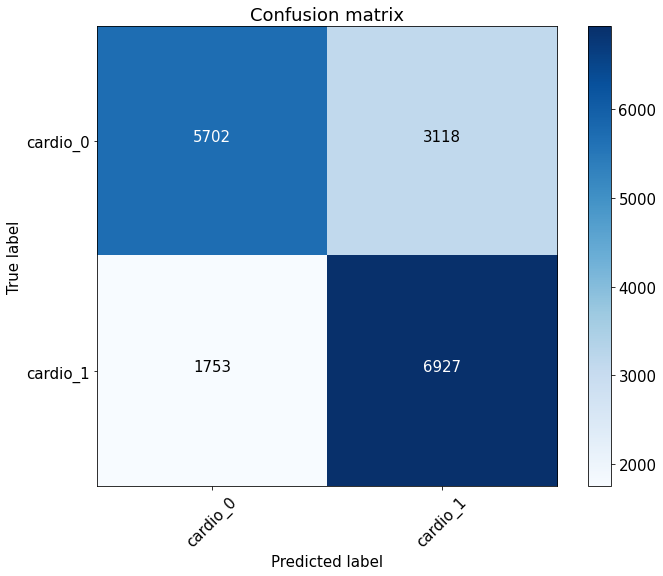

In [13]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

##### Задание 4
разобраться с SHAP и построить важности признаков для:
всего тестового набора данных (summary_plot - дать интерпретацию)
для 5 случайных объектов из тестового набора

In [11]:
import catboost
import shap

# pip install shap
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
df = pd.read_csv('train_case2.csv', ';')
features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'  ]
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [13]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df['cardio'], random_state=0)

##### LGBM

Отрисовка идет по двум классам

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


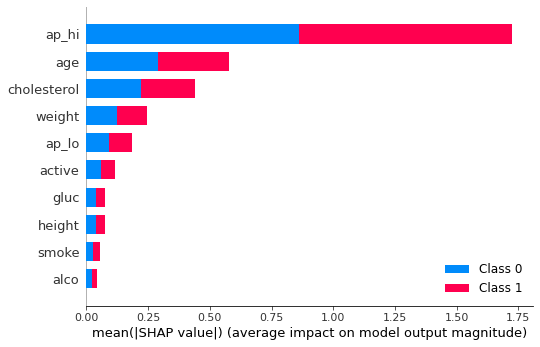

In [15]:
from lightgbm import LGBMClassifier # pip install lightgbm

lgb_model = LGBMClassifier(random_state=1)
lgb_model.fit(X_train, y_train)

y_preds = lgb_model.predict(X_test)

# строим модель объяснения в SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# покажем объяснение
shap.initjs() # для работы в колабе
shap.summary_plot(shap_values, X_test)

##### Поэтому будем анализировать только первый класс - целевой.

Explained expected value: [[-0.66151599  0.01788158 -0.07656626 ...  0.02110479  0.01745853
  -0.02972211]
 [ 0.0667463   0.01682766 -0.30963496 ...  0.02725556  0.01262059
  -0.04782418]
 [ 0.24965399 -0.02644673 -0.04479803 ...  0.01919697  0.0099122
  -0.05949432]
 ...
 [-0.4949116  -0.07489813 -0.07684773 ...  0.01636915  0.01312373
  -0.025519  ]
 [-0.10268403  0.05229029 -0.10152774 ...  0.01876799 -0.15515717
   0.08906871]
 [-0.05415256 -0.01613222 -0.04504444 ...  0.00571527  0.00393296
  -0.01912289]]


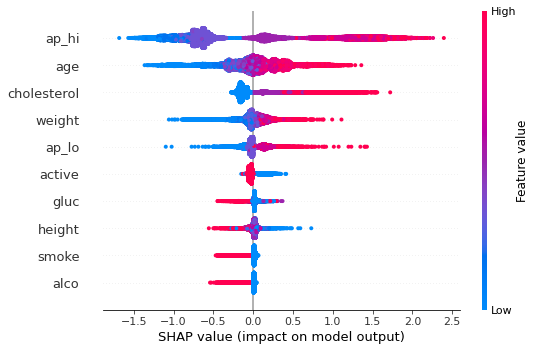

In [16]:
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print(f'Explained expected value: {shap_values}')

shap.summary_plot(shap_values, X_test)

In [17]:
X_train.shape

(52500, 10)

In [18]:
model = catboost.train({"learning_rate": 0.01, 'random_state': 1}, 
                      catboost.DMatrix(X_train, label=y_train), 100)


explainer = shap.TreeExplainer(model)
shap_values_all = explainer.shap_values(X_train)

shap.summary_plot(shap_values_all, X_train)

AttributeError: module 'catboost' has no attribute 'DMatrix'

In [ ]:
Для Винды этот атрибут недоступен,к сожалению.()